# Data exploration for city of Bremen

## Import required packages

In [3]:
import datetime
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
from shapely.ops import cascaded_union
from tqdm import tqdm
import json

## Import raw data

In [4]:
raw_data = pd.read_csv('../data/raw/bremen.csv')
raw_data.drop(columns=['Unnamed: 0'], inplace=True) # Drop second index column
raw_data.sample()

p_spot  p_place_type             datetime  b_number   trip   p_uid  \
585266    True             0  2019-03-14 00:00:00     90159  first  132525   

        p_bikes      p_lat  b_bike_type  \
585266        5  49.446615            4   

                                        p_name  p_number      p_lng  p_bike  
585266  Virnsberger Str. / Sigmundstr. (DATEV)    4667.0  11.007606   False

## Filter data for entrys of Bremen only
https://github.com/gboeing/urban-data-science/blob/master/19-Spatial-Analysis-and-Cartography/rtree-spatial-indexing.ipynb

### Import geodata of Bremen (PLZ based)

https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/table/?refine.note=Bremen

In [5]:
plz_df = gpd.read_file('../data/external/plz_bremen.geojson')

In [6]:
# Function that creates map with center such that all of Bremen is displayed.

def create_bremen_map(zoom = 11):
    
    m = folium.Map(location=[53.122962,8.7515937], zoom_start=zoom)
    
    return m

In [7]:
geo_data_bremen = create_bremen_map()

folium.Choropleth(plz_df).add_to(geo_data_bremen)

geo_data_bremen

### Get "boundaries" (min, max of latitude and longitude) of Bremen

In [8]:
boundaries = cascaded_union(plz_df.geometry).bounds
boundaries

(8.4815929, 53.0110367, 8.9907318, 53.22892479999999)

### Filter raw data such that we only keep data points within the boundaries of Bremen
- has to be done in preprocessor

#### Coarse filtering first for faster computation

In [9]:
bremen = raw_data[(raw_data['p_lat'] < boundaries[3]) &
         (raw_data['p_lat'] > boundaries[1]) &
         (raw_data['p_lng'] < boundaries[2])  &
         (raw_data['p_lng'] > boundaries[0])]

print(len(bremen))

1309128


## Total number of null values

- there are only null values (88) of the attribute p_number

In [10]:
bremen.isna().sum()

p_spot           0
p_place_type     0
datetime         0
b_number         0
trip             0
p_uid            0
p_bikes          0
p_lat            0
b_bike_type      0
p_name           0
p_number        88
p_lng            0
p_bike           0
dtype: int64

### Drop null values
- has to be done in preprocessor

In [11]:
bremen = bremen.dropna()

### Create geopandas data frame

In [12]:
bremen = gpd.GeoDataFrame(bremen, geometry=gpd.points_from_xy(bremen.p_lng.copy(), bremen.p_lat.copy()))

### Precise filtering for data points within Bremen

In [13]:
bremen = gpd.sjoin(bremen, plz_df[['geometry','plz']], how='left', op = 'within')

/home/channaholic/miniconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


#### Drop index of plz df and drop data points that are outside of Bremen borders

In [14]:
bremen = bremen.drop(columns=['index_right']).dropna()

## Reorder data frame
- has to be done in preprocessor

In [15]:
bremen = bremen[['datetime', 'b_number', 'p_spot', 'p_place_type',
                 'trip', 'p_uid', 'p_bikes', 'b_bike_type', 'p_name',
                 'p_number', 'p_bike', 'p_lat', 'p_lng','geometry', 'plz']]

# First explorations

## Total number of bookings (data points)

In [16]:
len(bremen)

1279878

## Total number of bikes - 443
- there are 443 different bikes presented in our data
- WESER-KURIER announced to provide 450 https://www.nextbike.de/de/news/start-fuer-wk-bike-in-bremen/

In [17]:
print(len(bremen.b_number.unique()))
print(bremen.b_number.unique())

443
[20668 20649 20964 20866 20799 20676 20855 20707 20815 20891 20721 20894
 20958 20942 20635 20838 20889 20827 20793 20797 20748 20791 20713 20790
 20810 20881 20817 20614 20768 20693 20626 20946 20915 20788 20684 20902
 20816 20704 20736 20912 20907 20769 20876 20943 20872 20924 20716 20968
 20761 20686 20804 20703 20967 20916 20756 20709 20725 20918 20903 20702
 20930 20688 20819 20690 20938 20843 20727 20874 20849 20651 20742 20751
 20658 20648 20904 20846 20697 20929 20669 20789 20859 20928 20854 20835
 20800 20771 20833 20937 20839 20935 20794 20715 20893 20621 20747 20900
 20667 20957 20712 20625 20657 20856 20888 20617 20766 20864 20724 20645
 20851 20805 20939 20921 20844 20731 20722 20934 20837 20719 20842 20899
 20734 20698 20616 20682 20743 20802 20735 20917 20858 20887 20798 20673
 20678 20932 20706 20896 20677 20806 20730 20732 20773 20630 20739 20679
 20687 20784 20647 20822 20832 20825 20738 20650 20685 20962 20906 20803
 20696 20922 20913 20670 20961 20963 20848 2084

### For a specific bike (b_number = 20668) check trips
- there seem to be many duplicates

In [18]:
bremen[bremen.b_number == 20668].sort_values('datetime')[:20]

datetime  b_number  p_spot  p_place_type   trip     p_uid  \
2241283  2019-01-20 00:00:00     20668   False            12  first  12097754   
2913437  2019-01-20 00:00:00     20668   False            12  first  12097754   
2241284  2019-01-20 01:33:00     20668   False            12   last  12097754   
2913438  2019-01-20 01:33:00     20668   False            12   last  12097754   
2242946  2019-01-22 09:15:00     20668    True             0  first   7873316   
2915100  2019-01-22 09:15:00     20668    True             0  first   7873316   
2242947  2019-01-22 09:42:00     20668    True             0  start   7873316   
2915101  2019-01-22 09:42:00     20668    True             0  start   7873316   
2242948  2019-01-22 09:49:00     20668   False            12    end  12155136   
2915102  2019-01-22 09:49:00     20668   False            12    end  12155136   
2242949  2019-01-22 14:52:00     20668   False            12  start  12155136   
2915103  2019-01-22 14:52:00     20668   False            12  start  12155136   
2242950  2019-01-22 15:35:00     20668   False            12    end  12162204   
2915104  2019-01-22 15:35:00     20668   False            12    end  12162204   
2915105  2019-01-22 23:59:00     20668   False            12   last  12162204   
2242951  2019-01-22 23:59:00     20668   False            12   last  12162204   
2916043  2019-01-23 00:00:00     20668   False            12  first  12162204   
2243889  2019-01-23 00:00:00     20668   False            12  first  12162204   
2916044  2019-01-23 10:42:00     20668   False            12   last  12162204   
2243890  2019-01-23 10:42:00     20668   False            12   last  12162204   

         p_bikes  b_bike_type                         p_name  p_number  \
2241283        1           71                     BIKE 20668       0.0   
2913437        1           71                     BIKE 20668       0.0   
2241284        1           71                     BIKE 20668       0.0   
2913438        1           71                     BIKE 20668       0.0   
2242946        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2915100        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2242947        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2915101        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2242948        1           71                     BIKE 20668       0.0   
2915102        1           71                     BIKE 20668       0.0   
2242949        1           71                     BIKE 20668       0.0   
2915103        1           71                     BIKE 20668       0.0   
2242950        1           71                     BIKE 20668       0.0   
2915104        1           71                     BIKE 20668       0.0   
2915105        1           71                     BIKE 20668       0.0   
2242951        1           71                     BIKE 20668       0.0   
2916043        1           71                     BIKE 20668       0.0   
2243889        1           71                     BIKE 20668       0.0   
2916044        1           71                     BIKE 20668       0.0   
2243890        1           71                     BIKE 20668       0.0   

         p_bike      p_lat     p_lng                  geometry    plz  
2241283    True  53.081698  8.812411  POINT (8.81241 53.08170)  28195  
2913437    True  53.081698  8.812411  POINT (8.81241 53.08170)  28195  
2241284    True  53.081767  8.812408  POINT (8.81241 53.08177)  28195  
2913438    True  53.081767  8.812408  POINT (8.81241 53.08177)  28195  
2242946   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2915100   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2242947   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2915101   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2242948    True  53.080356  8.795718  POINT (8.79572 53.08036)  28195  
2915102    True  53.080356  8.795718  POINT

## Check for duplicates

In [19]:
# Checking for duplicates regarding the timestamp and bike_number 
bremen.duplicated(subset=['datetime', 'b_number']).sum()

639939

## Drop duplicates - half of data (there is perfectly one duplicate per data point)
- has to be done in preprocessor

In [20]:
bremen = bremen[bremen.duplicated(subset=['datetime', 'b_number'], keep='first') == False]

In [21]:
len(bremen)

639939

## Specifications of p_bikes
- number of available bikes at position/station

In [22]:
bremen.p_bikes.unique()

array([ 1,  2,  3,  5,  4,  0,  7,  6,  8,  9, 11, 10, 12, 15, 14, 13, 16,
       17, 31, 30, 32, 28, 20, 25, 26, 18, 23, 21, 27, 22, 29, 19])

## Specifications of b_bike_type
- two different types of bikes

In [23]:
bremen.b_bike_type.unique()

array([71, 29])

## Specifications of p_bike
- if True in flex zone and not at station
- opposite of p_spot

In [24]:
bremen.p_bike.unique()


array([ True, False])

## Specifications of p_spot
- at fixed station area
- if True there is a p_name (name of fixed station)
- opposite of p_bike

In [25]:
bremen.p_spot.unique()

array([False,  True])

## Total number of p_uid
- unique ids of start and end locations
- includes 76 out of 83 ids of fixed stations

In [26]:
bremen.p_uid.nunique()

156809

- 76 out of 83 fixed stations are present in our data

In [27]:
len(bremen[bremen.p_spot == True].p_uid.unique())

73

## Import station data

In [28]:
stations = json_normalize(pd.read_json('../data/external/station_information.json').iloc[0,2])
stations.head(3)

station_id                       name short_name        lat       lon  \
0    2351602  WESER-KURIER | Pressehaus       2910  53.076722  8.803943   
1    7872668                  Am Dobben       2925  53.078194  8.823250   
2    7872701             Am Speicher XI       2926  53.097556  8.770056   

  region_id  capacity  
0       379       5.0  
1       379       NaN  
2       379       NaN

In [29]:
len(stations) # number of fixed stations

83

## Specifications of p_name
- name of start/end location
- partly contains weird names like coordinates

In [30]:
bremen.p_name.nunique()

5955

In [31]:
bremen[bremen.p_name.str[:4] != 'BIKE'].p_name.unique()

array(['WeserTower', 'Pusdorfer Marktplatz', 'GEWOBA | Ludwig-Beck 2a',
       ..., ' Faulenstraße 65', '53.082872, 8.812058',
       'recording_91000056'], dtype=object)

## Total number of p_number
- short ids for fixed stations
- 0 if not at fixed station but in flex zone

In [32]:
print(len(bremen.p_number.unique()))
print(bremen.p_number.unique())

76
[    0.  2971.  2959.  2988.  2927.  2910.  2933.  2972.  2912.  2941.
  2938.  2949.  2913.  2976.  2985.  2928. 29860.  2929.  2970.  2936.
  2986.  2946.  2952.  2963.  2967.  2975.  2966.  2947.  2958.  2940.
  2945.  2962.  2961.  2969.  2987.  2937.  2930.  2965.  2934.  2957.
  2950.  2939.  2942.  2911.  2951.  2955.  2925.  2990.  2932.  2931.
  2926.  2948.  2944.  2992.  2956.  2954.  2991.  2935.  2914.  2997.
  2977.  2964.  2974.  2960.  2973.  2968.  2989.  2915.  2916.  2917.
  2919.  2918.  2920.  2923.  2922.  2921.]


## Specifications of p_bikes
- number of available bikes at position/station

In [33]:
bremen.p_bikes.unique()

array([ 1,  2,  3,  5,  4,  0,  7,  6,  8,  9, 11, 10, 12, 15, 14, 13, 16,
       17, 31, 30, 32, 28, 20, 25, 26, 18, 23, 21, 27, 22, 29, 19])

In [34]:
bremen[bremen.p_spot == False].p_bikes.max() # can there be more than one bike if not in flex zone - yes

2

## Specifications of trip
- [start, end, first, last]  (do not refer to duplicates)
- more specific analysis of trip attribute in the creation process of trips down below

In [35]:
bremen.trip.unique()

array(['first', 'last', 'start', 'end'], dtype=object)

In [36]:
len(bremen[(bremen.trip != 'first') & (bremen.trip != 'last')])

454796

In [37]:
bremen['datetime'] = pd.to_datetime(bremen['datetime']) # parse timestamp to datetime

### Sort data frame by timestamp
- has to be done in preprocessor

In [38]:
bremen = bremen.sort_values('datetime')

In [39]:
bremen[bremen.b_number == 20668][:20]

datetime  b_number  p_spot  p_place_type   trip     p_uid  \
2241283 2019-01-20 00:00:00     20668   False            12  first  12097754   
2241284 2019-01-20 01:33:00     20668   False            12   last  12097754   
2242946 2019-01-22 09:15:00     20668    True             0  first   7873316   
2242947 2019-01-22 09:42:00     20668    True             0  start   7873316   
2242948 2019-01-22 09:49:00     20668   False            12    end  12155136   
2242949 2019-01-22 14:52:00     20668   False            12  start  12155136   
2242950 2019-01-22 15:35:00     20668   False            12    end  12162204   
2242951 2019-01-22 23:59:00     20668   False            12   last  12162204   
2243889 2019-01-23 00:00:00     20668   False            12  first  12162204   
2243890 2019-01-23 10:42:00     20668   False            12   last  12162204   
2246583 2019-01-25 07:46:00     20668    True             0  first   7873007   
2246584 2019-01-25 14:42:00     20668    True             0  start   7873007   
2246585 2019-01-25 14:56:00     20668   False            12    end  12232480   
2246586 2019-01-25 23:59:00     20668   False            12   last  12232480   
2247504 2019-01-26 00:00:00     20668   False            12  first  12232480   
2247505 2019-01-26 23:59:00     20668   False            12   last  12232480   
2248252 2019-01-27 00:00:00     20668   False            12  first  12232480   
2248253 2019-01-27 23:59:00     20668   False            12   last  12232480   
2248957 2019-01-28 00:00:00     20668   False            12  first  12232480   
2248958 2019-01-28 06:42:00     20668   False            12  start  12232480   

         p_bikes  b_bike_type                         p_name  p_number  \
2241283        1           71                     BIKE 20668       0.0   
2241284        1           71                     BIKE 20668       0.0   
2242946        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2242947        5           71  Hauptbahnhof / Übersee Museum    2946.0   
2242948        1           71                     BIKE 20668       0.0   
2242949        1           71                     BIKE 20668       0.0   
2242950        1           71                     BIKE 20668       0.0   
2242951        1           71                     BIKE 20668       0.0   
2243889        1           71                     BIKE 20668       0.0   
2243890        1           71                     BIKE 20668       0.0   
2246583        4           71                      Domsheide    2933.0   
2246584        4           71                      Domsheide    2933.0   
2246585        1           71                     BIKE 20668       0.0   
2246586        1           71                     BIKE 20668       0.0   
2247504        1           71                     BIKE 20668       0.0   
2247505        1           71                     BIKE 20668       0.0   
2248252        1           71                     BIKE 20668       0.0   
2248253        1           71                     BIKE 20668       0.0   
2248957        1           71                     BIKE 20668       0.0   
2248958        1           71                     BIKE 20668       0.0   

         p_bike      p_lat     p_lng                  geometry    plz  
2241283    True  53.081698  8.812411  POINT (8.81241 53.08170)  28195  
2241284    True  53.081767  8.812408  POINT (8.81241 53.08177)  28195  
2242946   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2242947   False  53.083167  8.811472  POINT (8.81147 53.08317)  28195  
2242948    True  53.080356  8.795718  POINT (8.79572 53.08036)  28195  
2242949    True  53.080453  8.795549  POINT (8.79555 53.08045)  28195  
2242950    True  53.062169  8.875182  POINT (8.87518 53.06217)  28207  
2242951    True  53.061929  8.875118  POINT (8.87512 53.06193)  28207  
2243889    True  53.061929  8.875118  POINT (8.87512 53.06193)  28207  
2243890    True  53.062032  8.875321  POINT (8.87532 53.06203) 

In [40]:
bremen[(bremen.b_number == 20668) & ((bremen.trip == 'first') & (bremen.datetime.dt.hour != 0))]

datetime  b_number  p_spot  p_place_type   trip     p_uid  \
2242946 2019-01-22 09:15:00     20668    True             0  first   7873316   
2246583 2019-01-25 07:46:00     20668    True             0  first   7873007   
2264984 2019-02-11 13:24:00     20668    True             0  first   7873893   
2311718 2019-02-28 14:19:00     20668   False            12  first  13051288   
2313106 2019-03-01 16:45:00     20668   False            12  first  13075883   
2348561 2019-03-19 09:28:00     20668   False            12  first  13428348   
2356371 2019-03-25 10:56:00     20668    True             0  first   8638942   
2369451 2019-04-01 06:33:00     20668   False            12  first  13917223   
2441464 2019-04-30 08:29:00     20668    True             0  first   7873316   
2445210 2019-05-01 03:51:00     20668    True             0  first   7873316   
2448107 2019-05-03 01:21:00     20668   False            12  first  15279482   
2462564 2019-05-10 05:53:00     20668    True             0  first   7873316   
2470775 2019-05-14 05:44:00     20668   False            12  first  15719683   
2493370 2019-05-24 11:26:00     20668    True             0  first   8806578   
2496349 2019-05-25 02:26:00     20668   False            12  first  16231426   
2577137 2019-06-25 07:38:00     20668   False            12  first  17977555   
2585326 2019-06-29 11:36:00     20668    True             0  first   7873781   
2589275 2019-08-01 06:25:00     20668   False            12  first  19874152   
2712527 2019-09-19 16:19:00     20668    True             0  first  10278729   
2754009 2019-10-09 06:11:00     20668    True             0  first   7873316   
2761804 2019-10-13 10:17:00     20668   False            12  first  23349750   
2795542 2019-10-27 01:00:00     20668   False            12  first  24034886   
2892454 2019-12-18 08:36:00     20668    True             0  first   7873893   
2895961 2019-12-20 08:11:00     20668    True             0  first   7873316   
2901625 2019-12-24 09:25:00     20668    True             0  first   7873316   

         p_bikes  b_bike_type                                    p_name  \
2242946        5           71             Hauptbahnhof / Übersee Museum   
2246583        4           71                                 Domsheide   
2264984        2           71                       Woltmershauser Str.   
2311718        1           71                                BIKE 20668   
2313106        1           71                                BIKE 20668   
2348561        1           71                                BIKE 20668   
2356371        4           71                             Föhrenstraße    
2369451        1           71                      Hamburger Straße 248   
2441464        5           71             Hauptbahnhof / Übersee Museum   
2445210        5           71             Hauptbahnhof / Übersee Museum   
2448107        1           71                                BIKE 20668   
2462564        5           71             Hauptbahnhof / Übersee Museum   
2470775        1           71                                BIKE 20668   
2493370        5           71                       GOP / Steigenberger   
2496349        1           71                                BIKE 20668   
2577137        1           71                                BIKE 20668   
2585326        4           71  Schwachhauser Heerstr. / Kirchbachstr.     
2589275        0           71                                BIKE 20668   
2712527        7           71                     GEWOBA | Heideplatz 1   
2754009        4           71             Hauptbahnhof / Übersee Museum   
2761804        1           71                                BIKE 20668   
2795542        1           71                                BIKE 20668   
2892454        6           71                       Woltmershauser Str.   
2895961       11           71             Hauptbahnhof / Übersee Museum   
2901625        1           71             Hauptbahnhof / Überse

In [41]:
# Visualizes number of trips clustered by locations

def plotDataPoints(latitudes, longitudes, zoom):
    
    # Create map centered at Bremens center
    m = create_bremen_map(zoom=zoom)
    
    marker_cluster = MarkerCluster().add_to(m)
        
    if len(latitudes) != len(longitudes):
        print('latitudes & longitudes must be the same size!')
    
    for i in range(len(latitudes)):
        
        lat = latitudes.iloc[i]
        lng = longitudes.iloc[i]
        
        folium.Circle(
            location=[lat,lng],
            radius=15,
            fill=True
        ).add_to(marker_cluster)
                  
    return m

## Visualization of 40000 randomly choosen data point locations

In [42]:
sample_points = bremen.sample(40000)

In [43]:
plotDataPoints(sample_points['p_lat'], sample_points['p_lng'], zoom=11).save('../reports/figures/samplevis_bremen_clustered.html')

# Creation of trips

Theoretically, each ping (this is what we call a record in the data) of a bike that has the trip attribute **start** should also have a counterpart ping with the attribute **end** and therefore the number of trips can be infered from the number of pings that "start" a trip. Let's check that:

In [44]:
print('start pings:', bremen[bremen['trip'] == 'start'].trip.count())
print('end pings:', bremen[bremen['trip'] == 'end'].trip.count())

start pings: 231134
end pings: 223662


There is a small deviation - keep that in mind, and only register a trip if there is a closing end ping for each start ping!

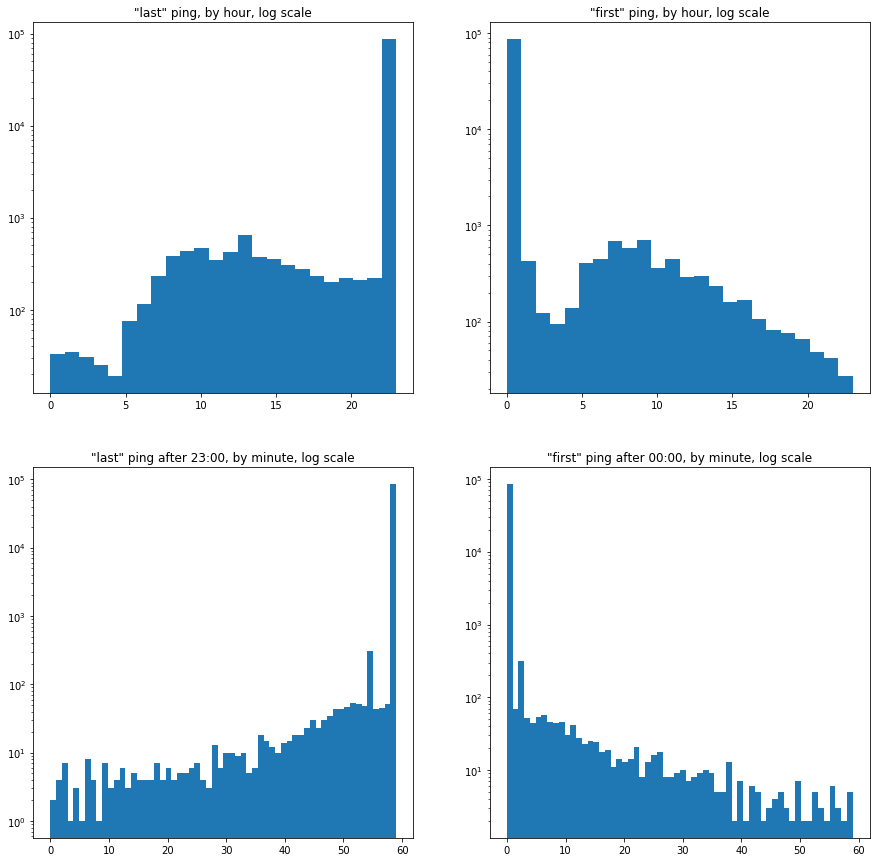

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0,0].hist(bremen[bremen['trip'] == 'last']['datetime'].dt.hour, bins=24, log=True)
ax[0,0].set_title('"last" ping, by hour, log scale')

ax[1,0].hist(bremen[(bremen['trip'] == 'last') & (bremen['datetime'].dt.hour == 23)]['datetime'].dt.minute, bins=60, log=True)
ax[1,0].set_title('"last" ping after 23:00, by minute, log scale')

ax[0,1].hist(bremen[bremen['trip'] == 'first']['datetime'].dt.hour, bins=24, log=True)
ax[0,1].set_title('"first" ping, by hour, log scale')

ax[1,1].hist(bremen[(bremen['trip'] == 'first') & (bremen['datetime'].dt.hour == 0)]['datetime'].dt.minute, bins=60, log=True)
ax[1,1].set_title('"first" ping after 00:00, by minute, log scale')

plt.show()

Most bikes have their last "ping" at **exactly 23:59** and their first "ping" at **exactly 00:00**.

We can assume these are just status pings that bikes/stations emit when a new day starts.
These can be safely omitted when creating trips. For all other occurrences we can assume these are trips that started on one day and ended on the next.

In [46]:
bremen[bremen['trip'].isin(['start', 'last'])].trip.count()

323763

According to that logic there would be over 300.000 trips - let's have a look.

In [47]:
ordered = bremen.sort_values(['b_number', 'datetime'], axis=0)

trips = []
buffer = None

def write_trip(ping, buffer):
    trip = {'bike': ping['b_number'],
            'bike_type': ping['b_bike_type'],
            'identification': ping['p_uid'],
            'start_time': buffer['datetime'],
            'end_time': ping['datetime'],
            'duration_sec': (ping['datetime'] - buffer['datetime']).total_seconds(),
            'start_lng': buffer['p_lng'],
            'start_lat': buffer['p_lat'],
            'end_lng': ping['p_lng'],
            'end_lat': ping['p_lat'],
            'start_place': buffer['p_number'],
            'end_place': ping['p_number'],
            'start_plz': buffer['plz'],
            'end_plz': ping['plz']
            }

    trips.append(trip)


for index, ping in tqdm(ordered.iterrows(), total=len(ordered), desc='Finished rows:'):

    bike = ping['b_number']
    trip = ping['trip']
    time = ping['datetime']
    lat = ping['p_lat']
    lng = ping['p_lng']

    if buffer is not None:

        buffer_bike = buffer['b_number']
        if bike != buffer_bike:
            # if records of the next bike start, overwrite buffer and continue
            buffer = ping
            continue

        buffer_trip = buffer['trip']
        buffer_time = buffer['datetime']
        buffer_lat = buffer['p_lat']
        buffer_lng = buffer['p_lng']

        if trip == 'first' and buffer_trip == 'last':
            # check for midnight trip
            if buffer_time.time() != datetime.time(23, 59) and time.time() != datetime.time(0, 0):

                # this was not just a checkout/checkin ping
                # now check if the bike has moved
                moved = (lat != buffer_lat) | (lng != buffer_lng)
                if moved:
                    write_trip(ping, buffer)
                    buffer = None

        elif trip == 'end' and buffer_trip == 'start':
            # write trip, discard buffer and continue
            write_trip(ping, buffer)
            buffer = None

        # 
        buffer = ping

    else:
        if trip == 'last' or trip == 'start':
            # only write buffer and start a potential trip with last and start trip attribute
            buffer = ping

trips = pd.DataFrame.from_records(trips)
print('Creating trips from data completed successfully.')

Finished rows:: 100%|██████████| 639939/639939 [03:10<00:00, 3360.20it/s]


Creating trips from data completed successfully.


In [48]:
trips.sample(5)

bike  bike_type  identification          start_time  \
13087   20543         71        14736284 2019-04-20 13:23:00   
9302    20533         71        20527136 2019-08-15 15:02:00   
156996  20847         71         7873118 2019-06-16 05:43:00   
165242  20863         71         7873825 2019-11-29 12:47:00   
197489  20928         71        12732840 2019-03-26 02:47:00   

                  end_time  duration_sec  start_lng  start_lat   end_lng  \
13087  2019-04-20 17:20:00       14220.0   8.837361  53.076587  8.836936   
9302   2019-08-15 15:31:00        1740.0   8.779008  53.054800  8.793577   
156996 2019-06-16 05:45:00         120.0   8.799861  53.060528  8.799861   
165242 2019-11-29 12:49:00         120.0   8.852417  53.107139  8.852417   
197489 2019-03-26 02:49:00         120.0   8.838158  53.028968  8.838158   

          end_lat  start_place  end_place start_plz end_plz  
13087   53.076271          0.0        0.0     28205   28203  
9302    53.088151          0.0        0.0     28199   28217  
156996  53.060528       2936.0     2936.0     28201   28201  
165242  53.107139       2963.0     2963.0     28359   28359  
197489  53.028968       2935.0     2935.0     28279   28279

In [49]:
print('Actual trips:', len(trips))

Actual trips: 228949


As we can see, there are a lot fewer actual trips, just by removing "trips" that indicate a status ping only (23:59-00:00), and those that do not have correct start and end pings. We still obtain more than 200.000 trips for the given timeframe. Let's look at something we previously did not care about: Roundtrips.

In [50]:
print('There are', trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].bike.count(), 'roundtrips')
print('This equals', trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].bike.count()/ len(trips) * 100, '%')

There are 85872 roundtrips
This equals 37.5070430532564 %


Wow, almost 40% of all trips are round trips, that start and end at **exactly** the same position. Let's look closer into that.

In [51]:
print('do not start/end at a fixed station:')
trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat']) & (trips['start_place'] == 0) & (trips['end_place'] == 0)].bike.count()

do not start/end at a fixed station:


48082

More than 50% of these roundtrips do not start/end at a station, which means the bike would've been rented and returned at exactly the same geo coordinates which is highly unlikely. Let's remove these. -> Add to Preprocessor!

In [52]:
trips = trips[~((trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat']) & (trips['start_place'] == 0) & (trips['end_place'] == 0))]
print('There are', trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].bike.count(), 'roundtrips')
print('This equals', trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].bike.count()/ len(trips) * 100, '%')

There are 37790 roundtrips
This equals 20.893805945805482 %


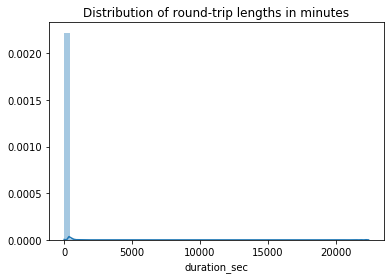

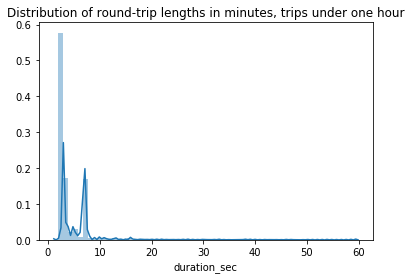

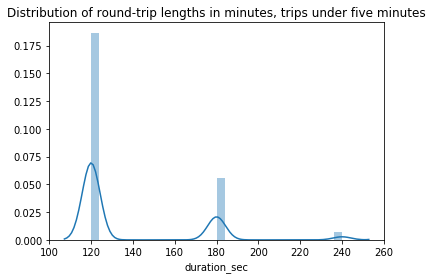

In [53]:
sns.distplot(trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat'])].duration_sec / 60)
plt.title('Distribution of round-trip lengths in minutes')
plt.show()
sns.distplot(trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat']) & (trips['duration_sec'] < 3600)].duration_sec / 60, bins=60)
plt.title('Distribution of round-trip lengths in minutes, trips under one hour')
plt.show()
sns.distplot(trips[(trips['start_lng'] == trips['end_lng']) & (trips['start_lat'] == trips['end_lat']) & (trips['duration_sec'] < 300)].duration_sec)
plt.title('Distribution of round-trip lengths in minutes, trips under five minutes')
plt.show()

As we can see, a huge portion of station-bound roundtrips (those that start and end at exactly the same latitude/longitude) are exactly 120 seconds and 180 seconds long - interesting.

According to https://www.nextbike.de/de/faq/ (see "Das Rahmenschloss öffnet nicht. Was soll ich tun?") a rental that is unsuccessful (because the lock doesn't open e.g.), is automatically returned after 3 minutes - 180 seconds. Bingo! Even though we were not able to find a similar mechanism that acts on the 2 minute (120 seconds) mark, we assume, something similar happens there.

To be sure, we remove roundtrips that are shorter than or equal to 3 minutes - it is highly unlikely that such trips are real.
-> Also add this to the Preprocessor!

In [54]:
trips = trips[trips['duration_sec'] > 180]
print(len(trips), 'trips remain')

149826 trips remain


We conclude, that after preprocessing, we still have almost 150.000 trips that we can work with and be somewhat sure they are real.

# Data Exploration

In [55]:
display(trips.head(), trips.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149826 entries, 0 to 228948
Data columns (total 14 columns):
bike              149826 non-null int64
bike_type         149826 non-null int64
identification    149826 non-null int64
start_time        149826 non-null datetime64[ns]
end_time          149826 non-null datetime64[ns]
duration_sec      149826 non-null float64
start_lng         149826 non-null float64
start_lat         149826 non-null float64
end_lng           149826 non-null float64
end_lat           149826 non-null float64
start_place       149826 non-null float64
end_place         149826 non-null float64
start_plz         149826 non-null object
end_plz           149826 non-null object
dtypes: datetime64[ns](2), float64(7), int64(3), object(2)
memory usage: 17.1+ MB


bike  bike_type  identification          start_time            end_time  \
0   20507         29        10278649 2019-04-14 16:02:00 2019-04-14 16:09:00   
1   20507         29        10278649 2019-04-15 16:08:00 2019-04-15 16:15:00   
8   20507         29        14776184 2019-04-21 17:34:00 2019-04-21 17:47:00   
10  20507         29        10278649 2019-04-23 17:55:00 2019-04-23 20:13:00   
13  20507         29        10278649 2019-04-24 10:38:00 2019-04-24 20:19:00   

    duration_sec  start_lng  start_lat   end_lng    end_lat  start_place  \
0          420.0   8.884911  53.078923  8.884911  53.078923       2985.0   
1          420.0   8.884911  53.078923  8.884911  53.078923       2985.0   
8          780.0   8.884911  53.078923  8.899906  53.078711       2985.0   
10        8280.0   8.884911  53.078923  8.884911  53.078923       2985.0   
13       34860.0   8.884911  53.078923  8.884911  53.078923       2985.0   

    end_place start_plz end_plz  
0      2985.0     28329   28329  
1      2985.0     28329   28329  
8         0.0     28329   28327  
10     2985.0     28329   28329  
13     2985.0     28329   28329

None

In [56]:
# sort starting time
trips = trips.sort_values(by=['start_time'], ascending=True)

In [57]:
# create new features/columns: month, weekday, date of booking
for col in ['start_time']:
    trips['month'] = pd.DatetimeIndex(trips['start_time']).month
    trips['booking_date'] = trips.start_time.dt.date
    trips['weekdays'] = pd.DatetimeIndex(trips['start_time']).weekday

# Analyzing trip duration in sum

In [58]:
trips["duration_sec"].describe().astype(int)   

count      149826
mean        15108
std        223306
min           240
25%           480
50%           780
75%          1320
max      21399300
Name: duration_sec, dtype: int64

To have a better understanding of the numbers, we will translate this into minutes

In [59]:
# create duration min, to better understand the data
trips["duration_min"] = trips["duration_sec"]/60

In [60]:
trips["duration_min"].describe().astype(int)

count    149826
mean        251
std        3721
min           4
25%           8
50%          13
75%          22
max      356655
Name: duration_min, dtype: int64

- As we can see here, we have at least one outlier (max 356.655 minutes). 
- 75% of the trips have a duration of ≤ 22 minutes, but the mean is 251 minutes, while the median is 13 minutes. This means, that we have a positive skew, which indicates outliers as well
- Additionally, we have a high standard deviation of 3721 minutes. 

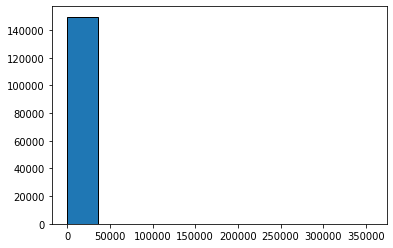

In [61]:
#Booking period (rented_minutes) for each booking -> frequency distribution
plt.hist(trips["duration_min"], bins = 10,edgecolor='k')
plt.show()

In [62]:
trips[trips["duration_min"]== 356655] 
## Question: Is this a booking mistake? Who rents a bike for 8 months?

bike  bike_type  identification          start_time  \
214119  20961         71         7873893 2019-03-10 20:08:00   

                  end_time  duration_sec  start_lng  start_lat   end_lng  \
214119 2019-11-13 12:23:00    21399300.0   8.805269  53.091262  8.779235   

          end_lat  start_place  end_place start_plz end_plz  month  \
214119  53.078581          0.0     2966.0     28215   28197      3   

       booking_date  weekdays  duration_min  
214119   2019-03-10         6      356655.0

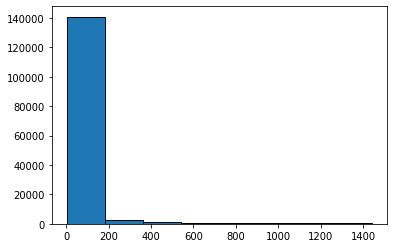

In [63]:
#lets have a look at the distribution of bookings with a duration less than 1 day
subsetRentedminutes = trips[trips["duration_min"].dropna(axis = 0) < 1441]  # 14726 entries in this subset
plt.hist(subsetRentedminutes["duration_min"], bins = 8 ,edgecolor='k')
plt.show()

In [64]:
(len(trips)-len(subsetRentedminutes))/len(trips)

0.019642785631332347

Only two percent of all the bookings are longer than one day. We decided to drop those two precent -> add to preprocessor

In [65]:
trips = trips[trips["duration_min"].dropna(axis = 0) < 1440]


In [66]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146881 entries, 80400 to 111800
Data columns (total 18 columns):
bike              146881 non-null int64
bike_type         146881 non-null int64
identification    146881 non-null int64
start_time        146881 non-null datetime64[ns]
end_time          146881 non-null datetime64[ns]
duration_sec      146881 non-null float64
start_lng         146881 non-null float64
start_lat         146881 non-null float64
end_lng           146881 non-null float64
end_lat           146881 non-null float64
start_place       146881 non-null float64
end_place         146881 non-null float64
start_plz         146881 non-null object
end_plz           146881 non-null object
month             146881 non-null int64
booking_date      146881 non-null object
weekdays          146881 non-null int64
duration_min      146881 non-null float64
dtypes: datetime64[ns](2), float64(8), int64(5), object(3)
memory usage: 21.3+ MB


In [67]:
trips["duration_min"].describe().astype(int)

count    146881
mean         39
std         125
min           4
25%           8
50%          13
75%          22
max        1439
Name: duration_min, dtype: int64

Let's see, how it changed:

75% of the trips still have a duration of ≤ 22 minutes, an the mean is 39 minutes (259 minutes compared above), while the median is stil 13 minutes. This means, that we have a positive skew, but not as skew as earlier.
Now, we have a lower standard deviation of 125 minutes (compated to 3721 minutes).

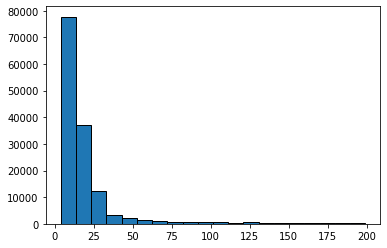

In [68]:
#lets have a look at the distribution of bookings with a duration less than 200 minutes
subsetRentedminutes_200 = trips[trips["duration_min"].dropna(axis = 0) < 200]
plt.hist(subsetRentedminutes_200["duration_min"], bins = 20 ,edgecolor='k')
plt.show()

In [69]:
subsetRentedminutes_200["duration_min"].describe().astype(int)

count    141272
mean         19
std          25
min           4
25%           7
50%          12
75%          20
max         199
Name: duration_min, dtype: int64

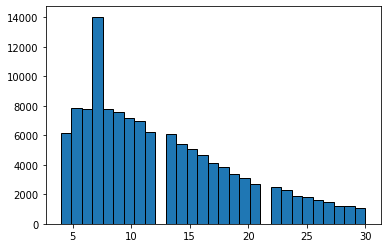

In [70]:
#lets have a look at the distribution of bookings with a duration less than 31 minutes
subsetRentedminutes_30 = trips[trips["duration_min"].dropna(axis = 0) < 31]
plt.hist(subsetRentedminutes_30["duration_min"], bins = 29 ,edgecolor='k')
plt.show()

In [71]:
subsetRentedminutes_30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125174 entries, 80400 to 111800
Data columns (total 18 columns):
bike              125174 non-null int64
bike_type         125174 non-null int64
identification    125174 non-null int64
start_time        125174 non-null datetime64[ns]
end_time          125174 non-null datetime64[ns]
duration_sec      125174 non-null float64
start_lng         125174 non-null float64
start_lat         125174 non-null float64
end_lng           125174 non-null float64
end_lat           125174 non-null float64
start_place       125174 non-null float64
end_place         125174 non-null float64
start_plz         125174 non-null object
end_plz           125174 non-null object
month             125174 non-null int64
booking_date      125174 non-null object
weekdays          125174 non-null int64
duration_min      125174 non-null float64
dtypes: datetime64[ns](2), float64(8), int64(5), object(3)
memory usage: 18.1+ MB


Only 2% of the trips are longer than 1 day. 141.272 trips take less than 200 minutes.
If we have an even closer look we can see that 125174 bookings have a duration of less than 30 minutes.
The last graphic displays the distribution of bookings less than 30 minutes and we can see, that half of the trips are  short trips up to approximately 10-15 minutes.

In [72]:
#Sum rented minutes a day
day_rented_minutes = (trips.groupby('booking_date')
                                 .duration_min.sum()
                              )
day_rented_minutes.describe().astype(int)



count       312
mean      18704
std       11337
min        2373
25%       10409
50%       16741
75%       24462
max      121754
Name: duration_min, dtype: int64

We have only bookings on 312 days of the year, many days are missing totally.
Here, we can see again that the mean is less robust next to the median, we have a positive skew.

In [73]:
#defining a lineplot: data = dataset; xlabel; ylabel; filename = give it a filename, to save the lineplot as .png
def lineplot (data, xlabel, ylabel, filename): 
    Fig_1 = plt.figure(figsize=(15,6),dpi = 300)
    ax = Fig_1.add_axes([0,0,1,1])

    ax.plot(data)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel) 
    plt.savefig("../reports/figures/"+ str(filename)+".png", bbox_inches='tight')

/home/channaholic/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


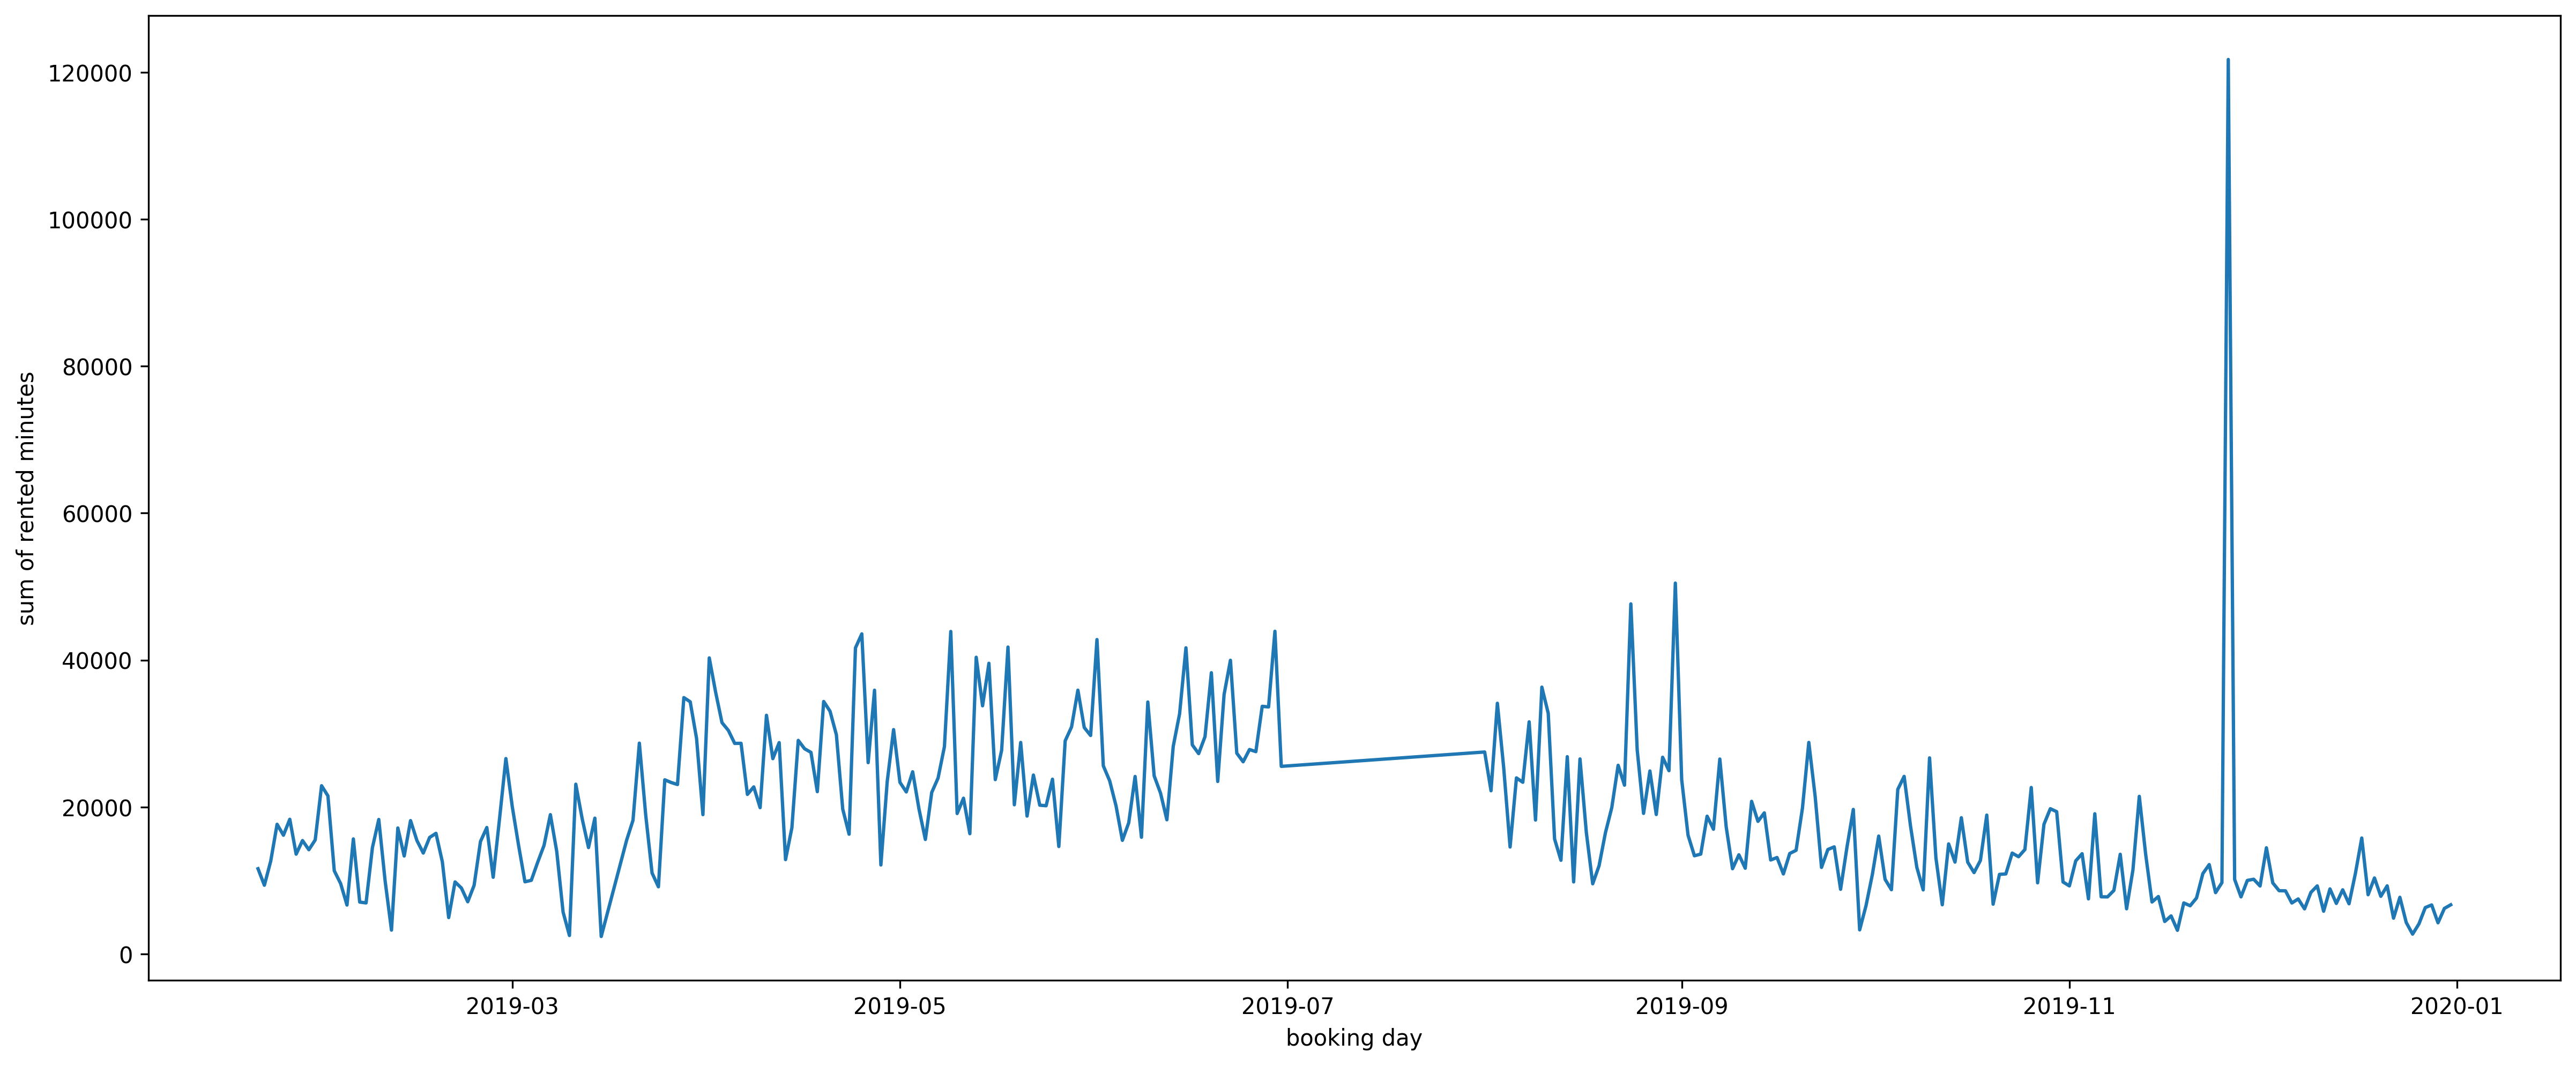

In [74]:
lineplot(day_rented_minutes,"booking day", "sum of rented minutes", "daily_rented_minutes")

We can see a seasonal trend here, but let's have a closer look on this:

In [75]:
#Sum rented minutes a day <200 min duration
sub_day_rented_minutes_200 = (subsetRentedminutes_200.groupby('booking_date')
                                 .duration_min.sum()
                              )
sub_day_rented_minutes_200.describe().astype(int)

count      312
mean      8814
std       4012
min       1843
25%       5886
50%       8197
75%      11094
max      24480
Name: duration_min, dtype: int64

In [76]:
#Sum rented minutes a day <30 min duration
sub_day_rented_minutes_30 = (subsetRentedminutes_30.groupby('booking_date')
                                 .duration_min.sum()
                              )
sub_day_rented_minutes_30.describe().astype(int)

count      312
mean      5042
std       1988
min        525
25%       3615
50%       5024
75%       6557
max      11598
Name: duration_min, dtype: int64

If we have a look at the subsets of rented minutes below 200 or 30 minutes, we see that mean and median are closer to each other, which implicates a less skewed distribution. 
Additionally, the standard deviation is not higher than the mean anymore. 

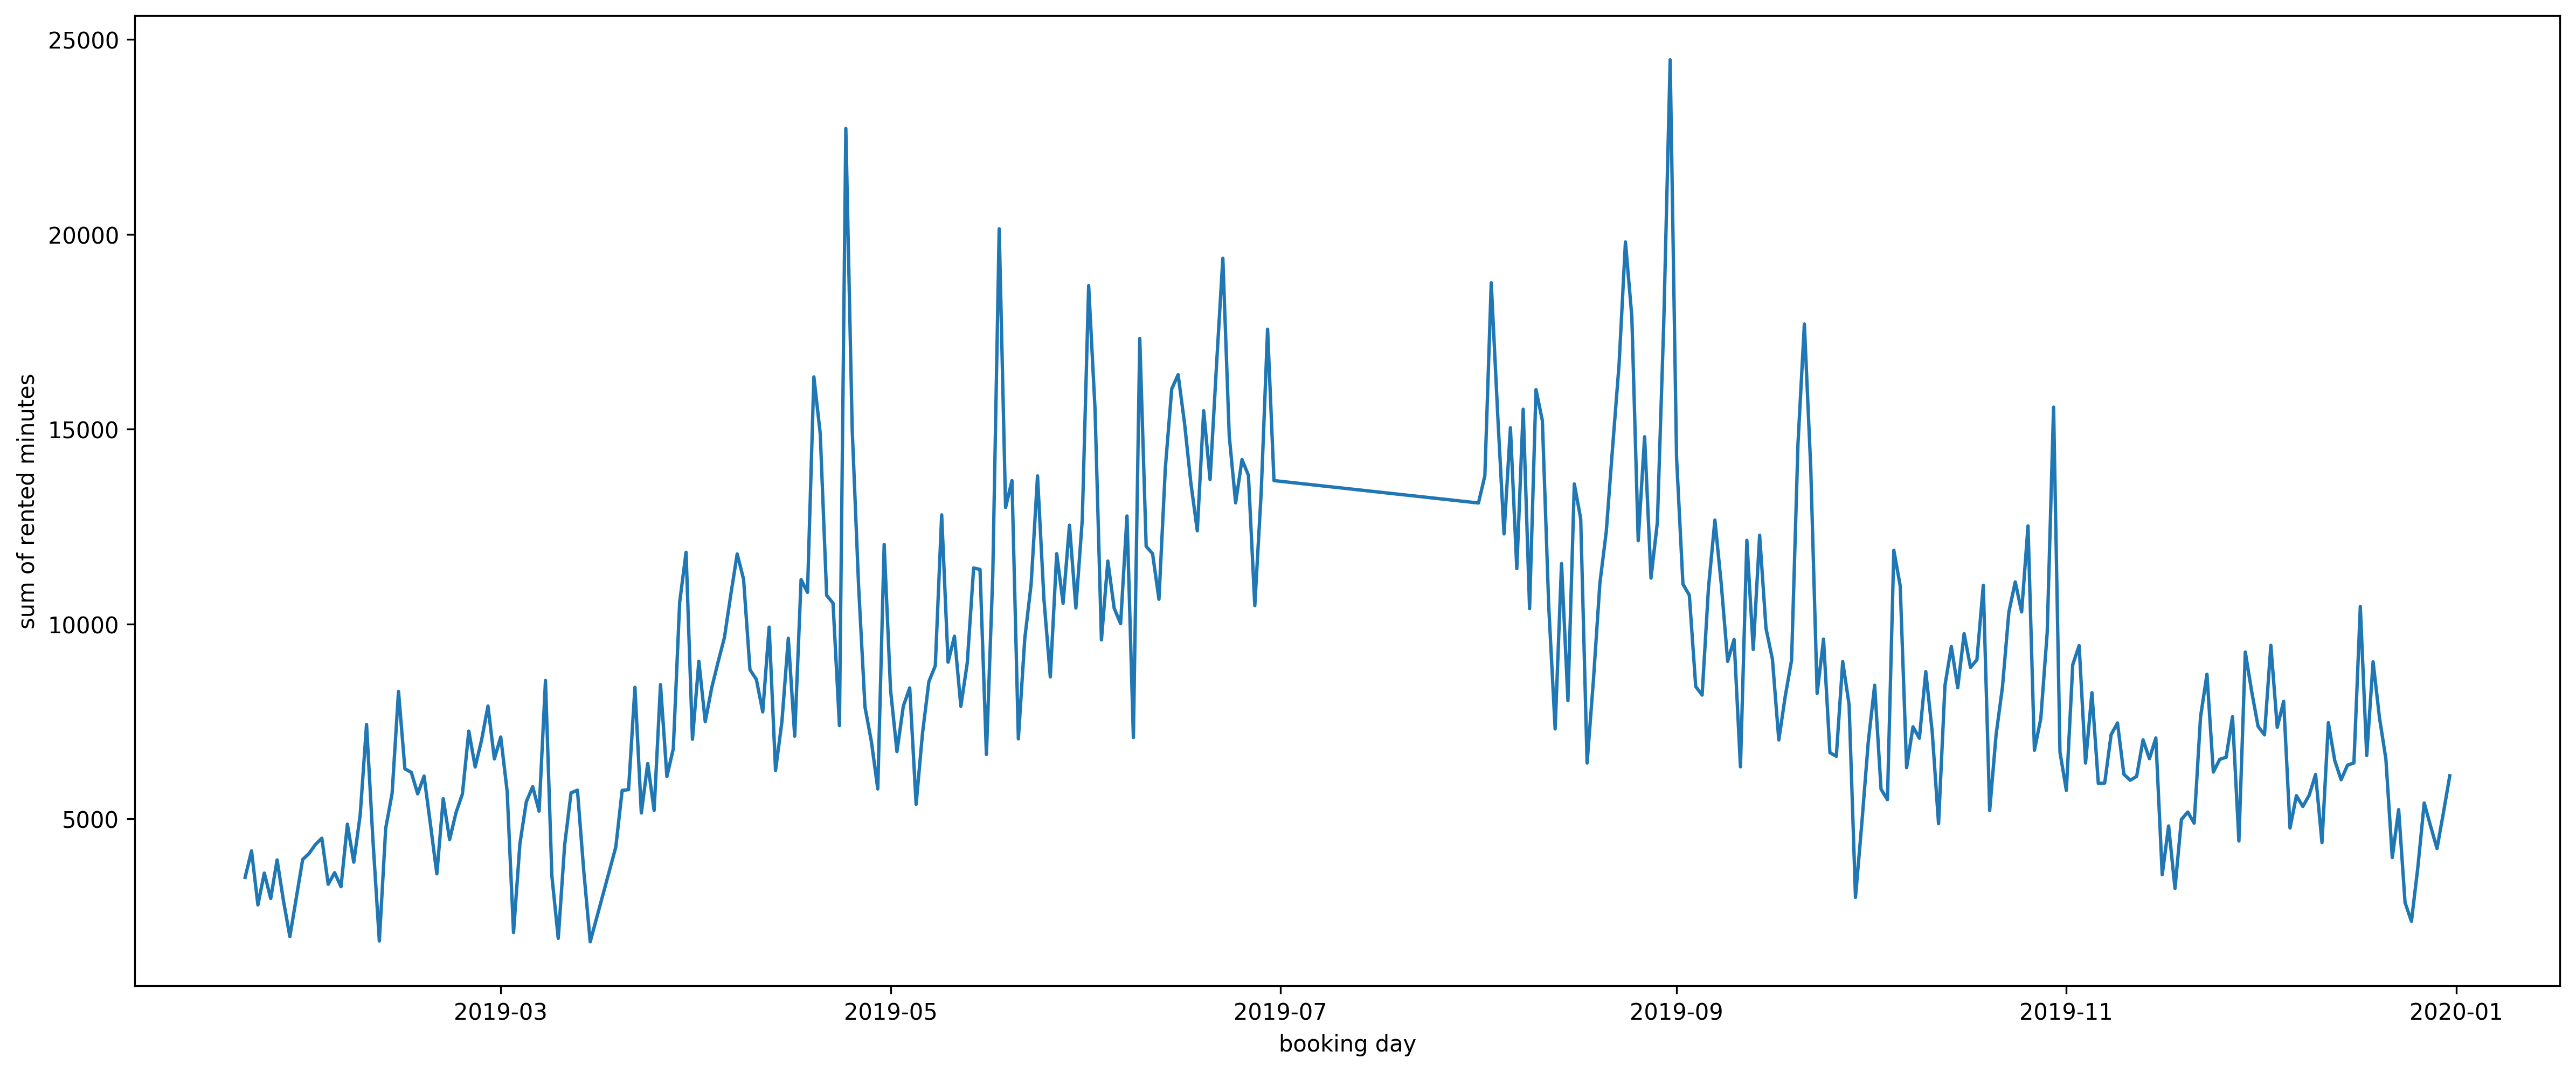

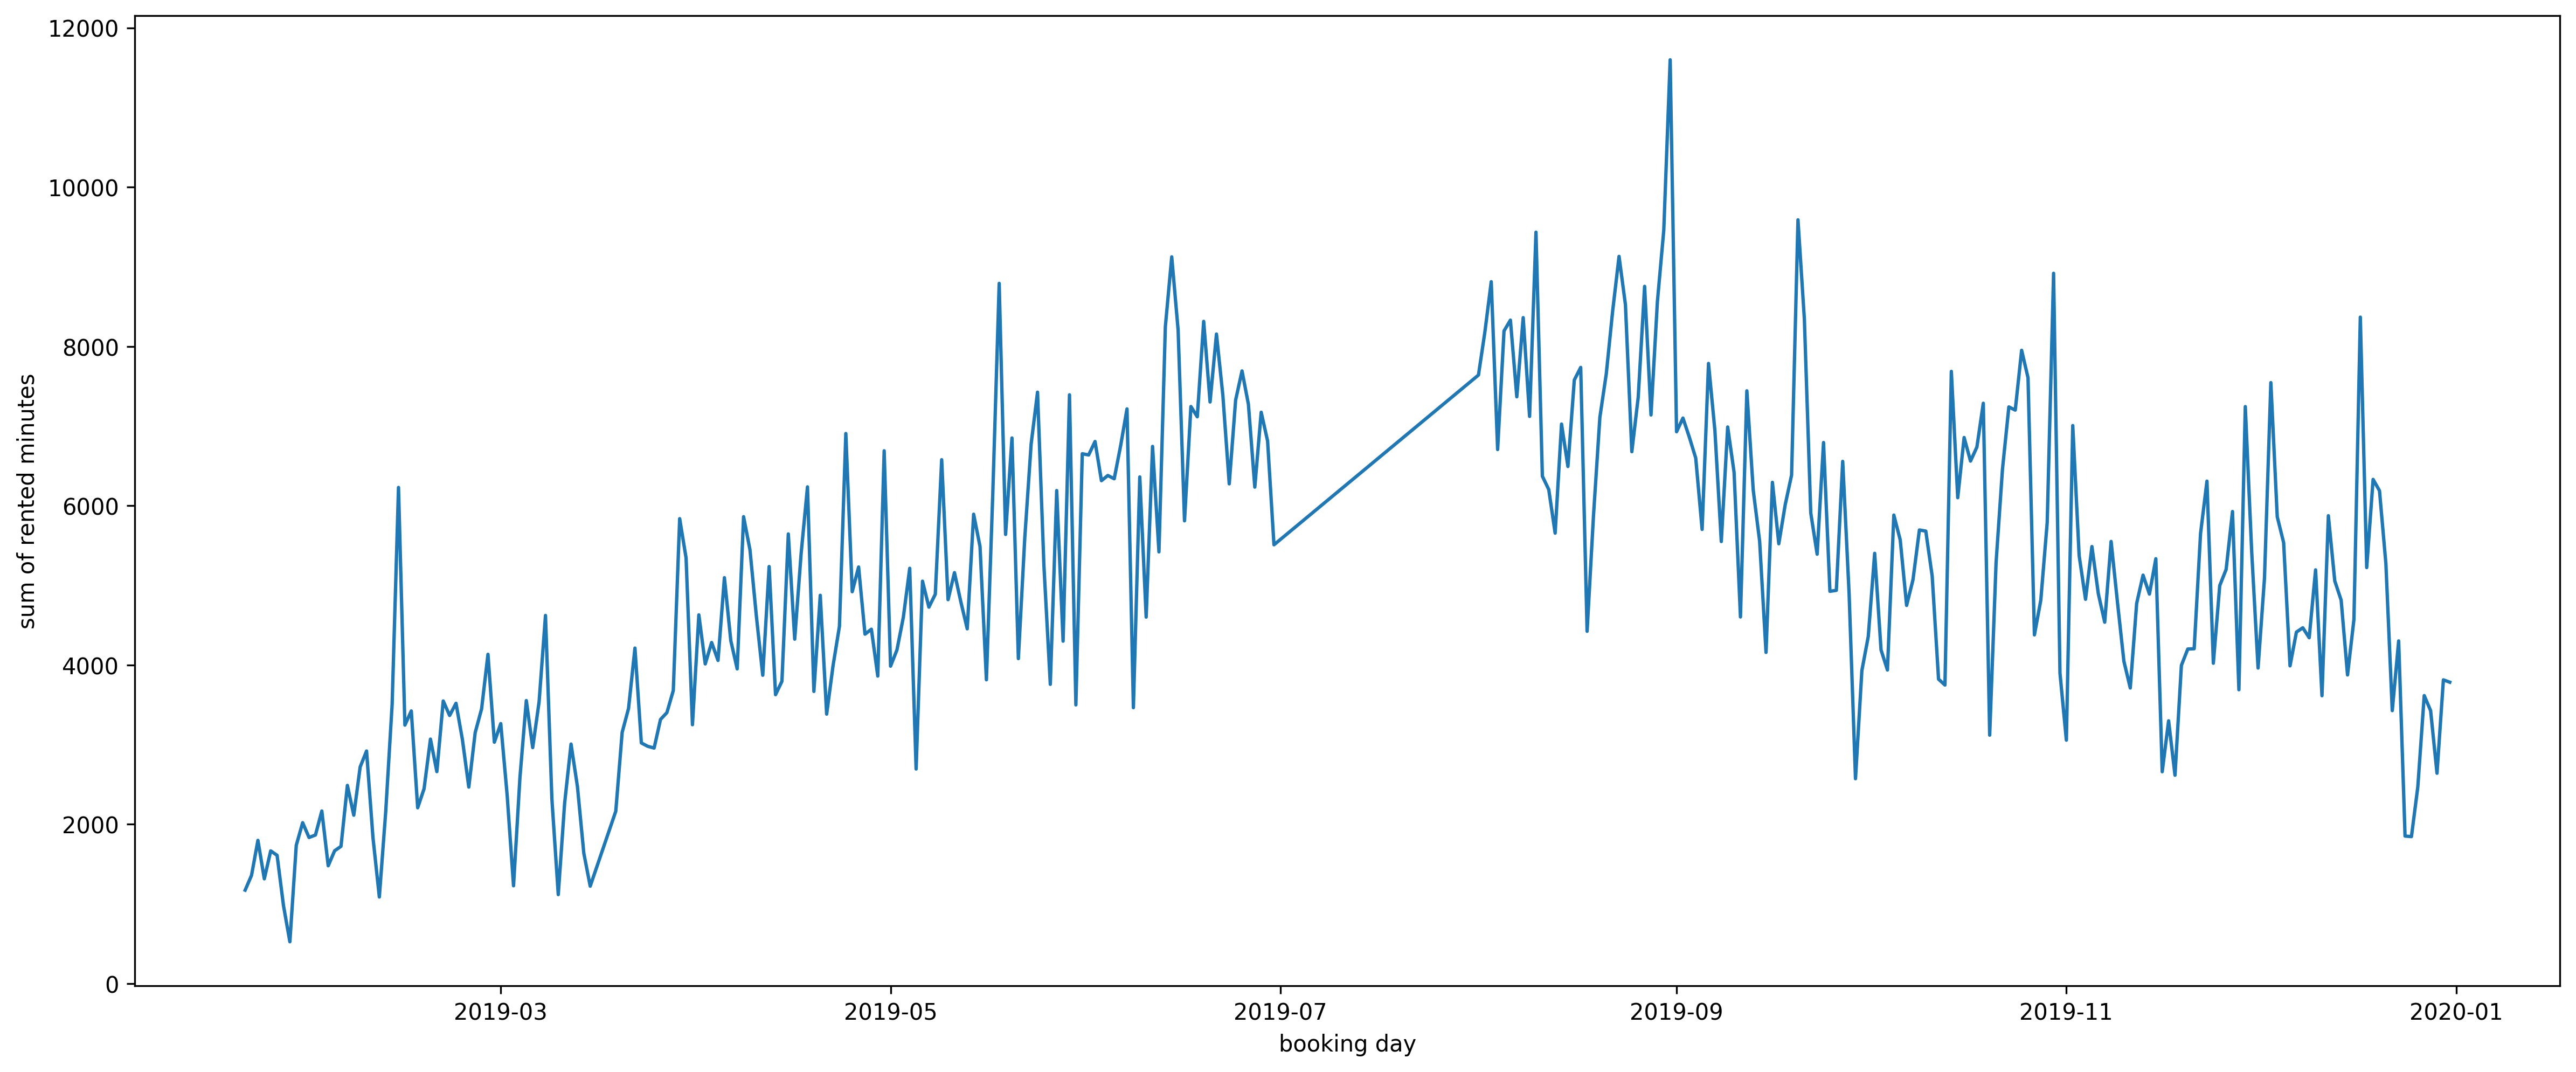

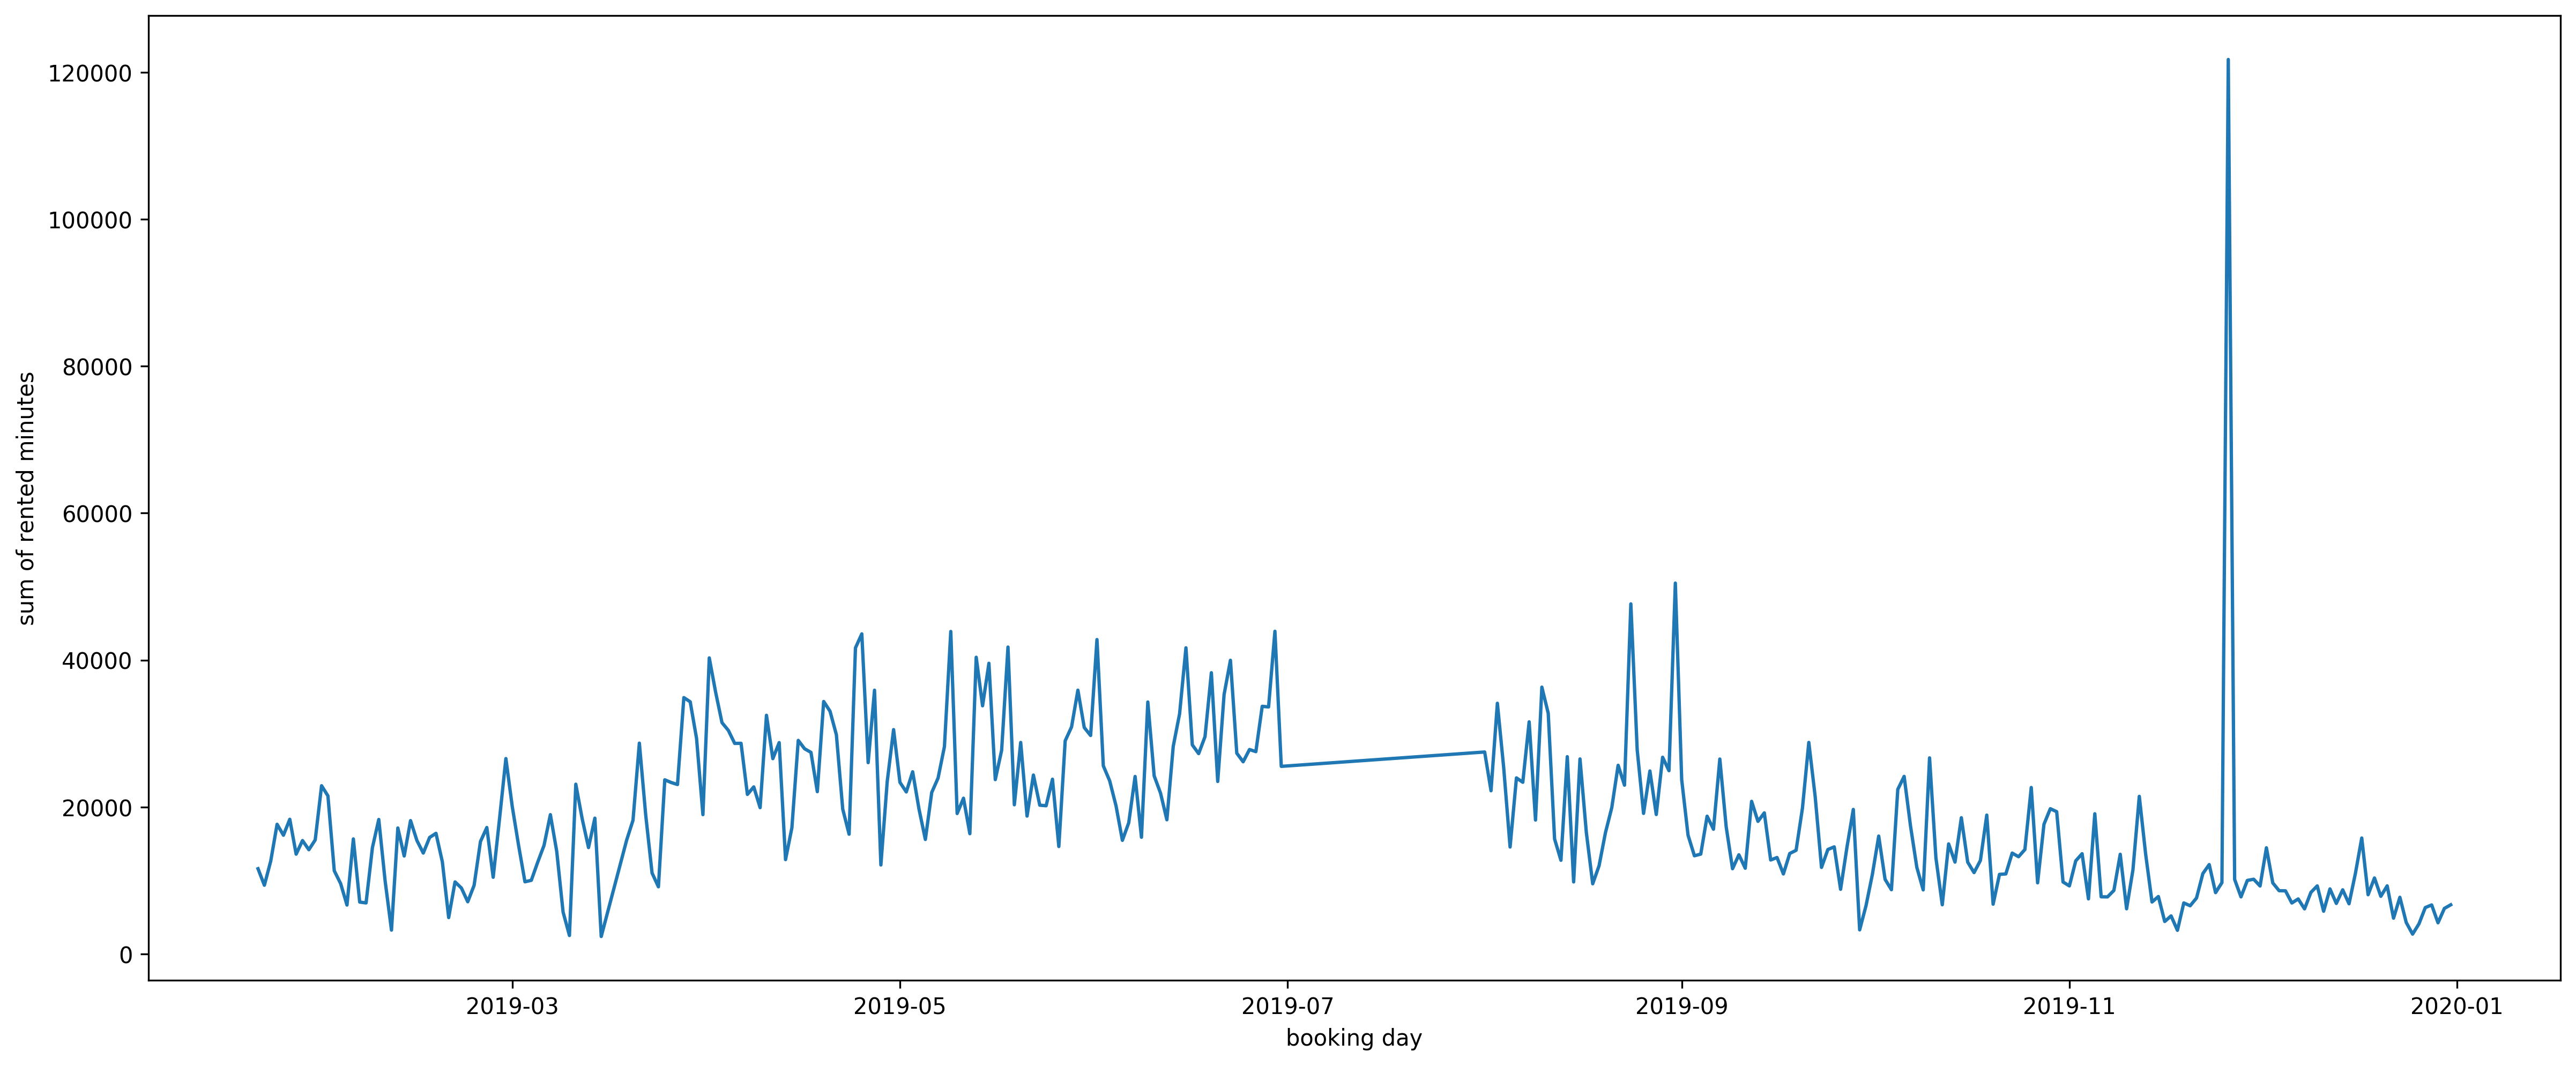

In [77]:
#display trips, so we can see a trend:
lineplot(sub_day_rented_minutes_200,"booking day", "sum of rented minutes", "sub_day_rented_minutes2" )
lineplot(sub_day_rented_minutes_30,"booking day", "sum of rented minutes","sub_day_rented_minutes3" )
lineplot(day_rented_minutes,"booking day", "sum of rented minutes", "sub_day_rented_minutes" )



If we exclude the outlier we can see a much better trend.

# Analyzing trip duration on average

In [78]:
# rented minutes on average per day
avg_rented_minutes = (trips.groupby('booking_date')
                                 .duration_min.mean()
                              )
avg_rented_minutes.describe().astype(int)

count    312
mean      41
std       23
min       12
25%       24
50%       36
75%       51
max      165
Name: duration_min, dtype: int64

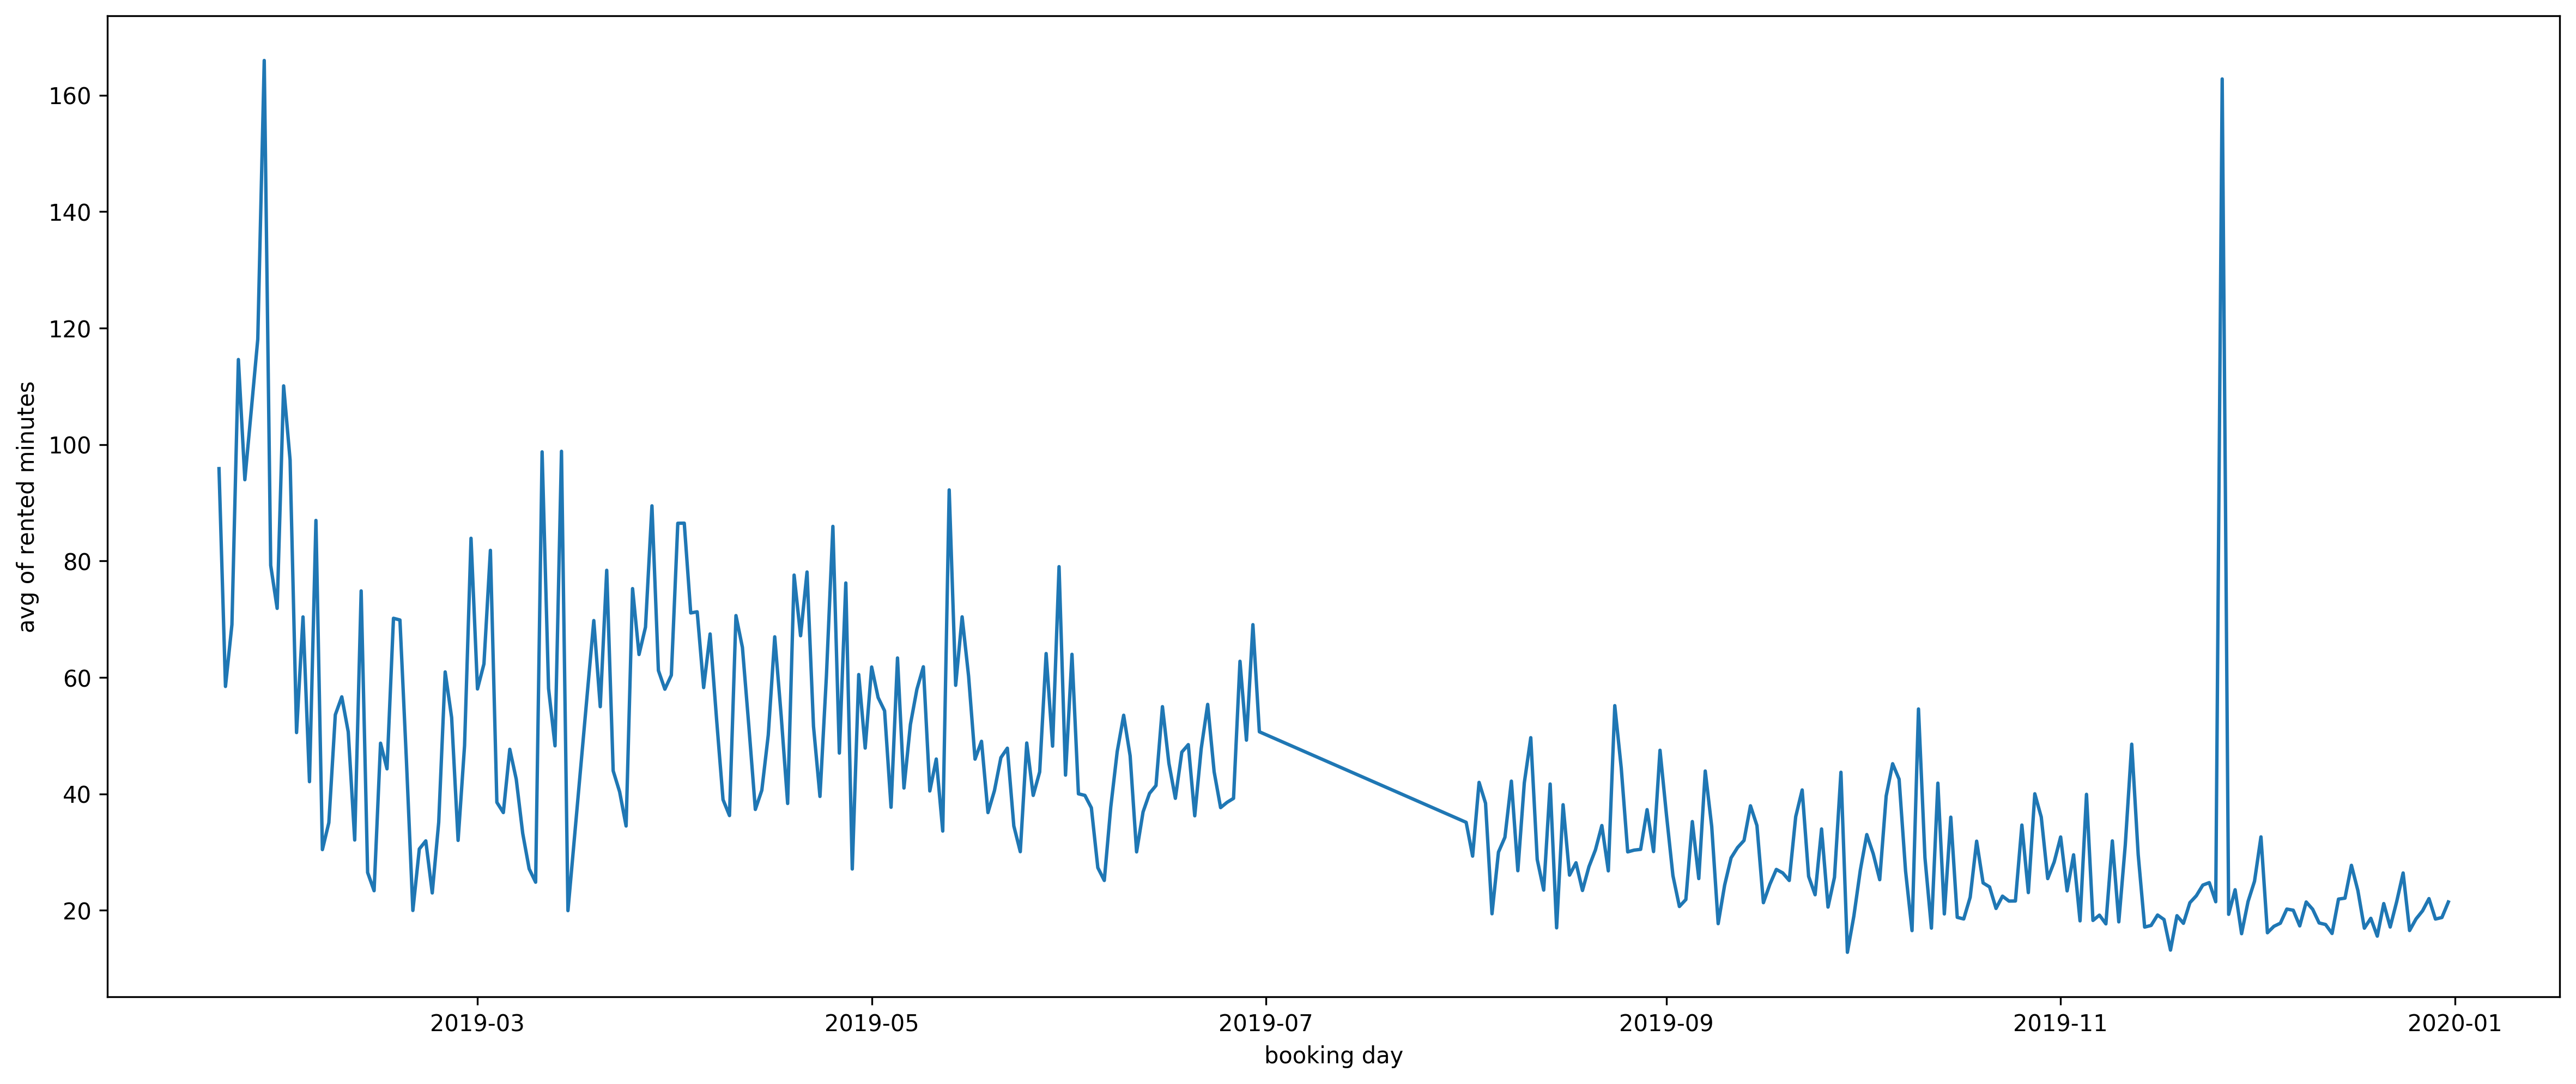

In [79]:
lineplot(avg_rented_minutes,'booking day','avg of rented minutes',"avg_rented_minutes" )

January looks suprising and needs to be analysed further, becuase it seems that the average trip duration the highest in January/February which is counter intuitiv.

# Number of bookings per day

In [80]:
# demand daily bookings dataset bremen trips
day_bookings_trips= (trips.groupby("booking_date").booking_date.count())
day_bookings_trips.describe().astype(int)

count     312
mean      470
std       178
min        93
25%       340
50%       460
75%       606
max      1063
Name: booking_date, dtype: int64

The median and mean are quite close. The standard deviation is not high. This can look quite similar to a normal distribution

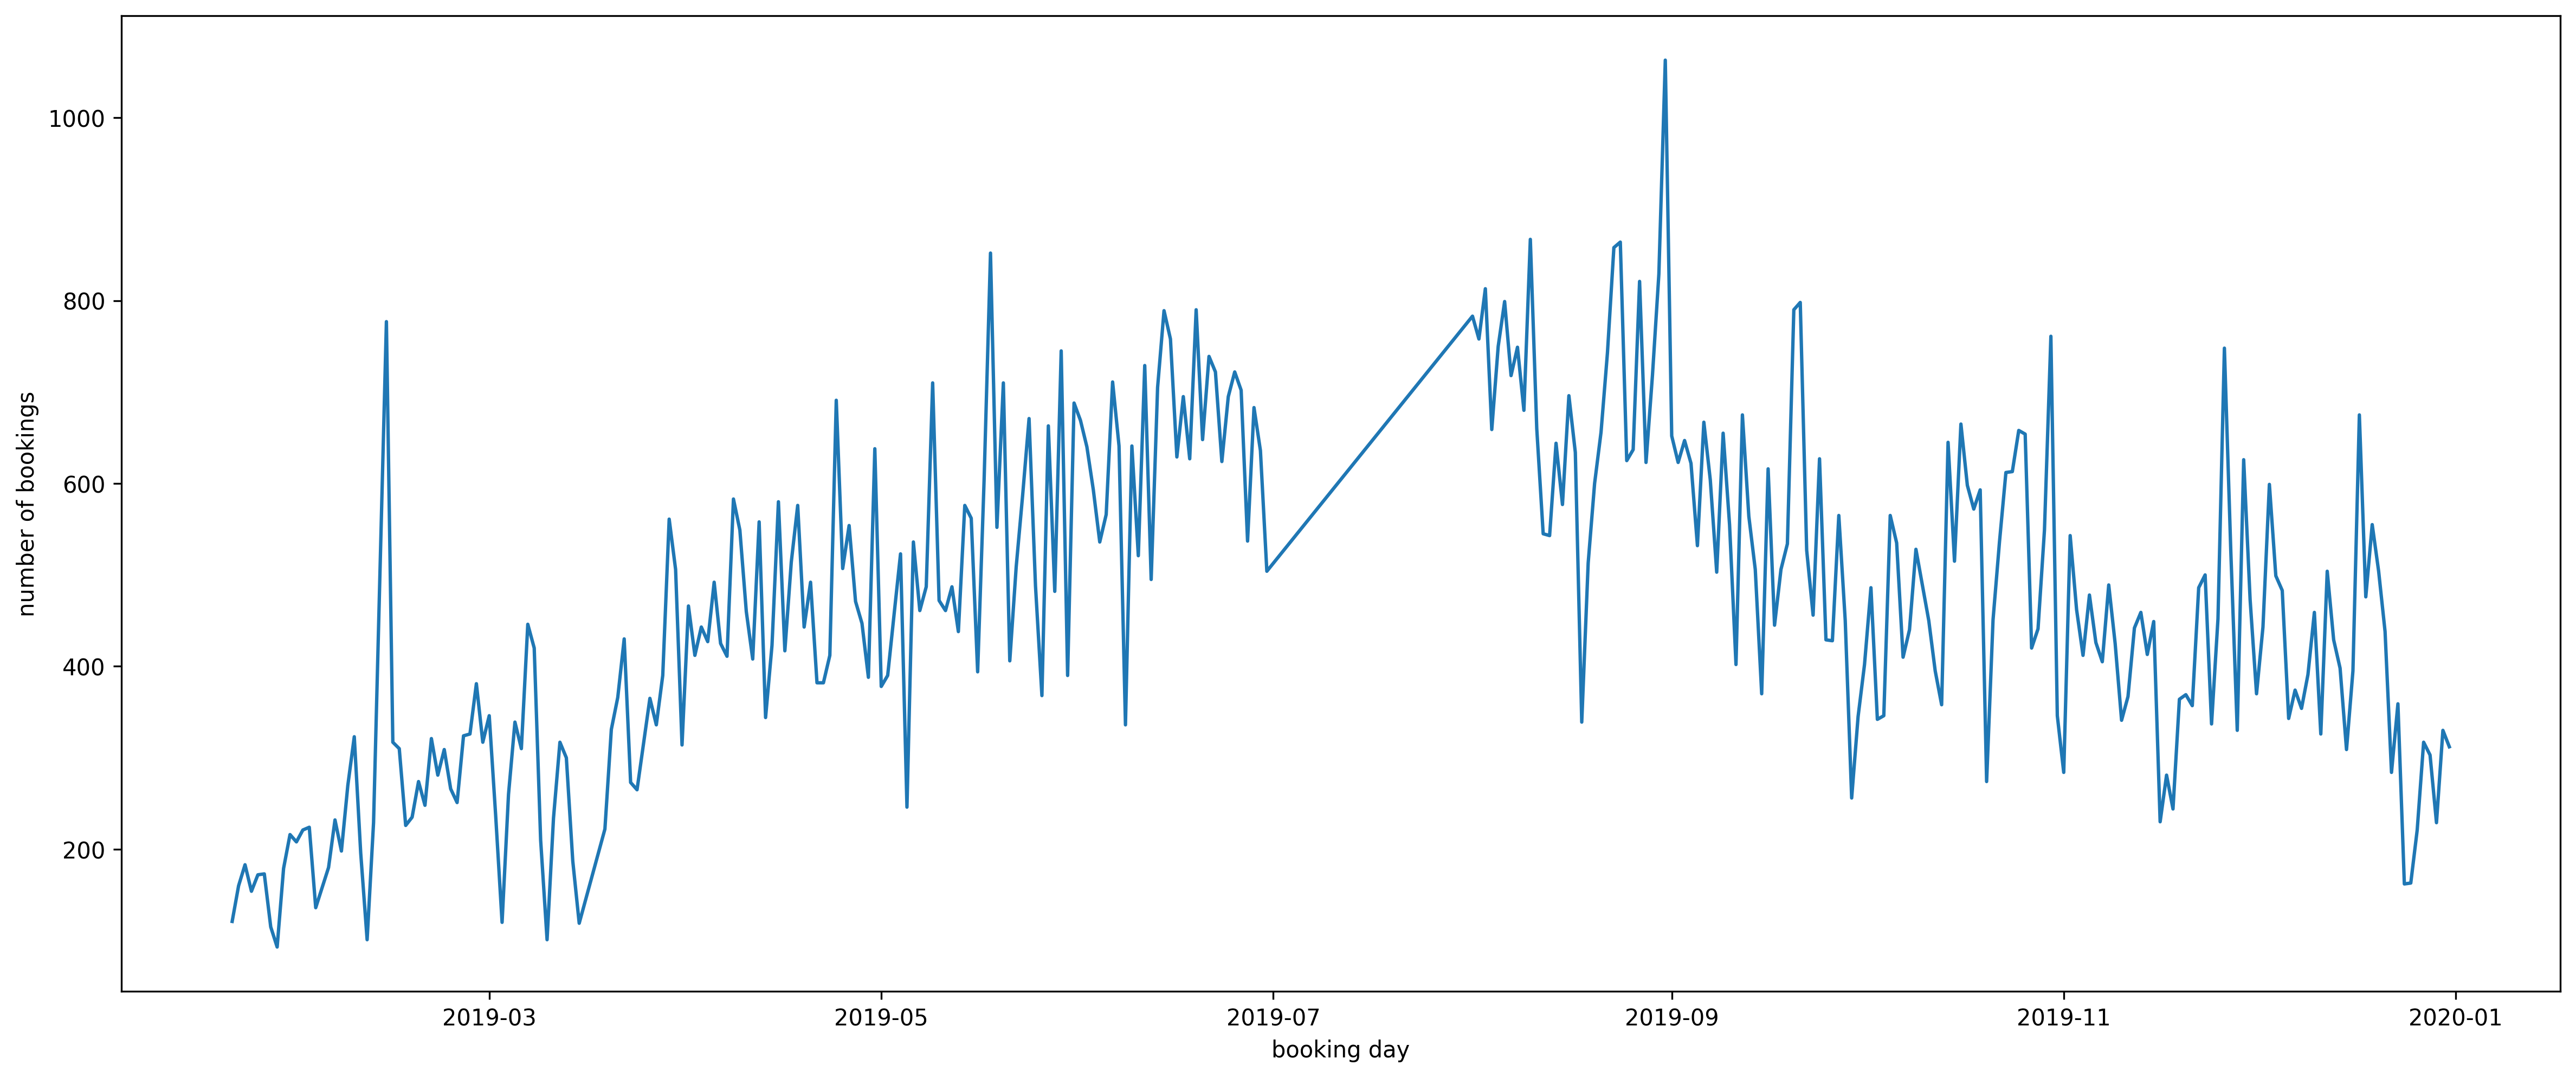

In [81]:
#Lineplot daily demand bookings: dataset bremen trips
lineplot(day_bookings_trips,"booking day","number of bookings", "day_bookings_trips" )

In [82]:
sub_day_bookings_trips = day_bookings_trips[day_bookings_trips < 2000]

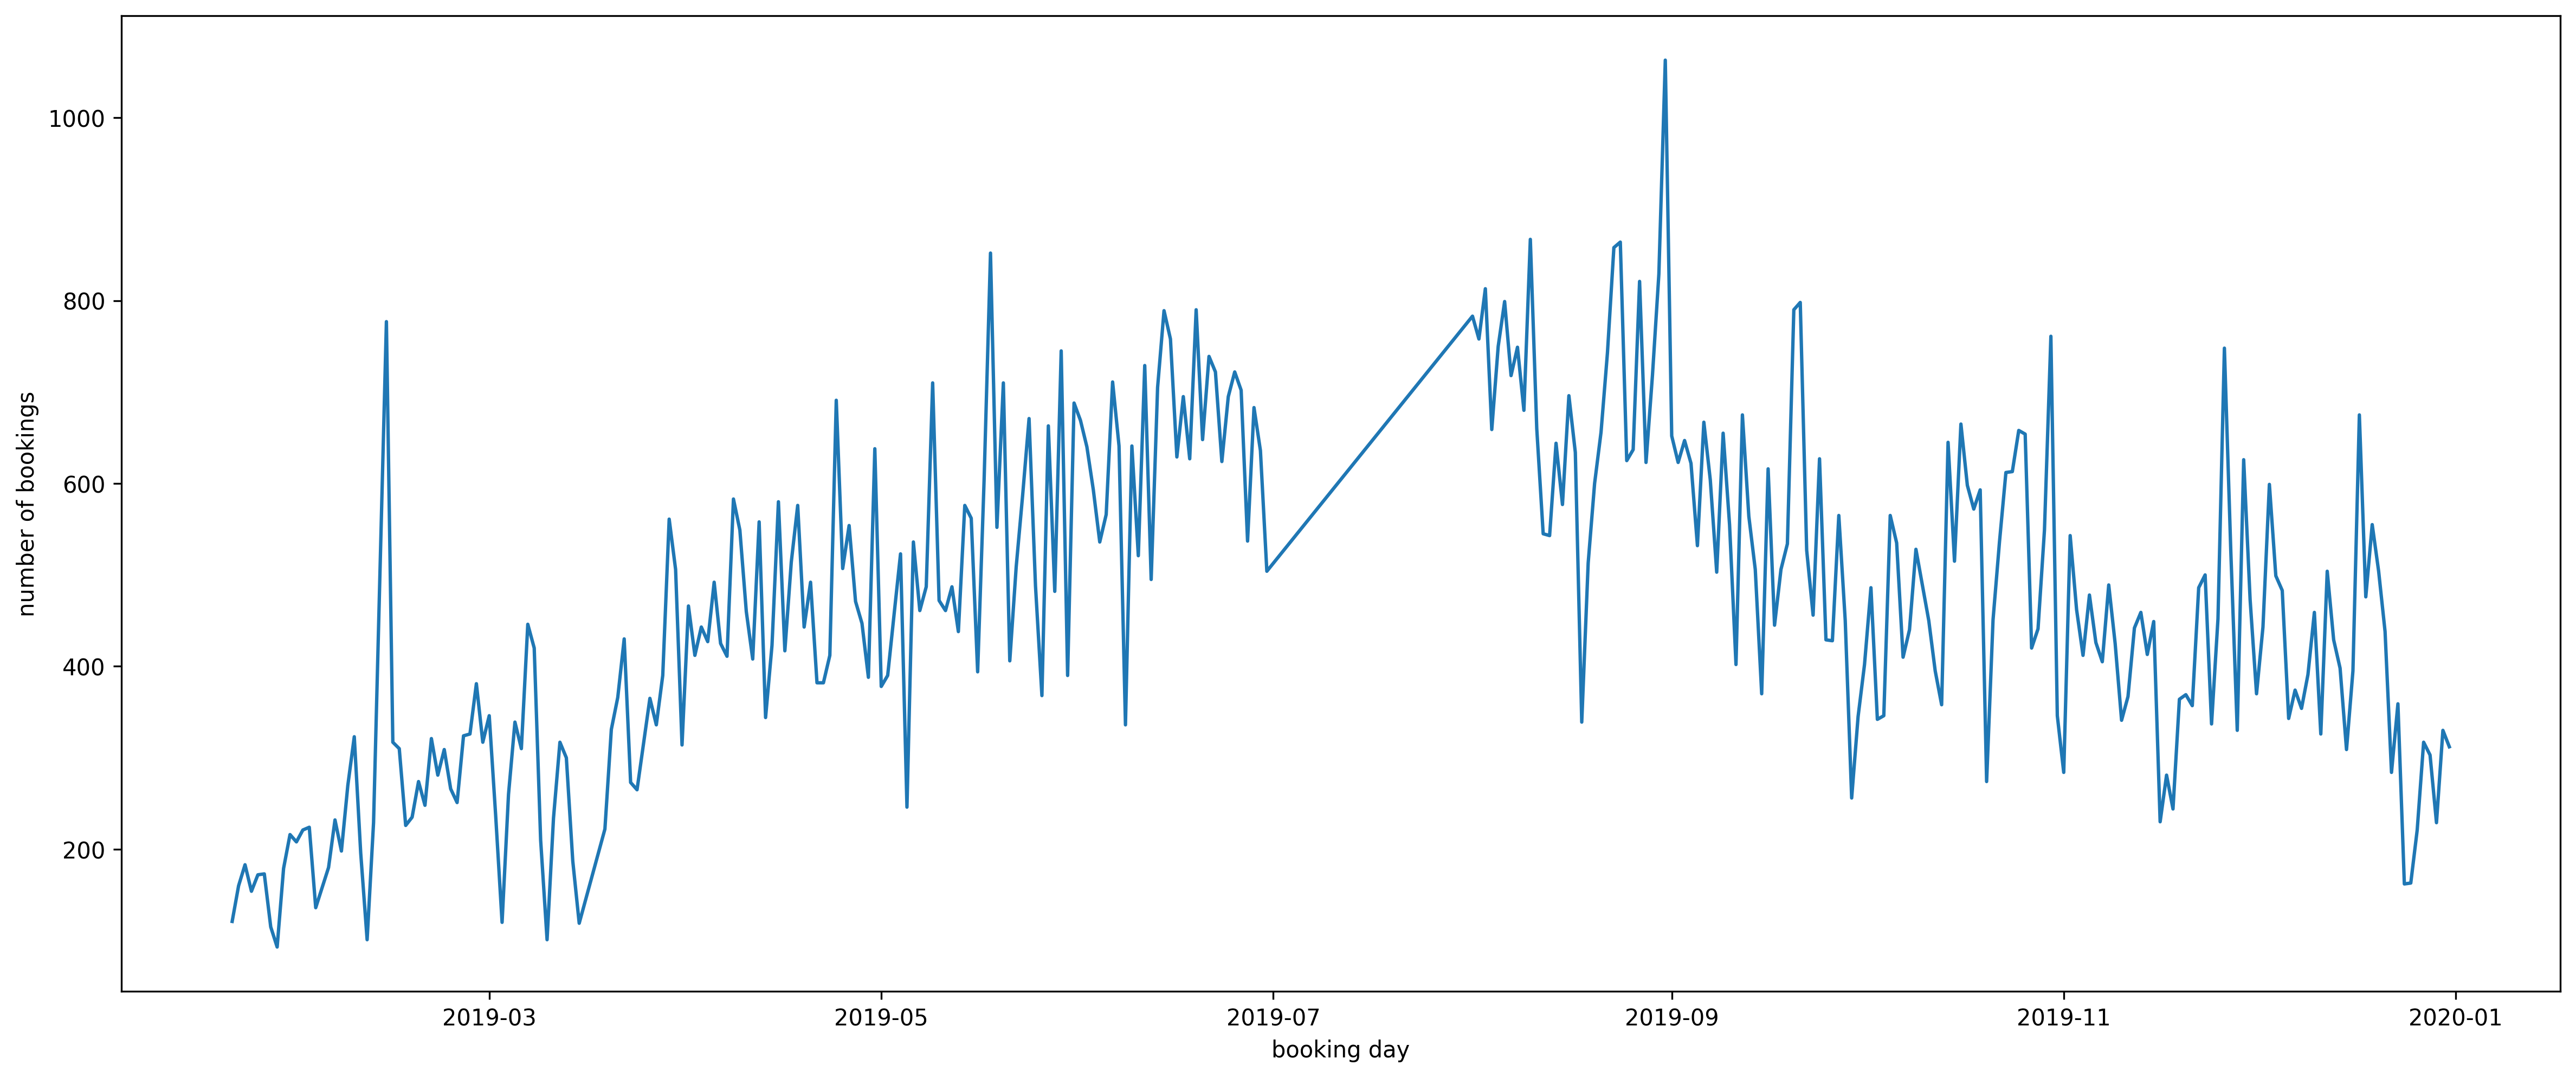

In [83]:
lineplot(sub_day_bookings_trips,"booking day","number of bookings", "sub_day_bookings_trips" )

We can see a seasonal trend. During the summer months we have more bookings as compared to winter. Compared to the average duration graph this is even a bigger contrast to it.

# Analyzing trip duration for different time frames

In [84]:
#Sum rented minutes a month
month_rented_minutes = (trips.groupby('month')
                                 .duration_min.sum()
                              )
month_rented_minutes.describe().astype(int)

count        11
mean     530536
std      241269
min      188846
25%      378029
50%      469145
75%      779853
max      854689
Name: duration_min, dtype: int64

In [85]:
month_rented_minutes # july is missing

month
1     188846.0
2     353811.0
3     488897.0
4     830385.0
5     814496.0
6     854689.0
8     745210.0
9     469145.0
10    446404.0
11    402248.0
12    241773.0
Name: duration_min, dtype: float64

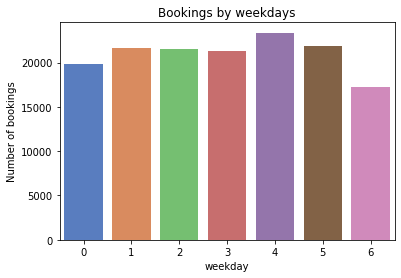

In [88]:
#Number of bookings by days of the week
weekdays = trips.groupby("weekdays").start_time.count()
weekdays
ax = sns.barplot(x=weekdays.index, y=weekdays, palette="muted")
ax.set(ylabel='Number of bookings', xlabel='weekday')
ax.set_title('Bookings by weekdays')
plt.savefig("../reports/figures/bookings_by_weekdays.png", dpi = 300)

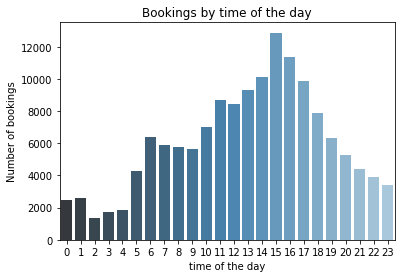

In [89]:
#Number of bookings by time
hour_day = trips.start_time.dt.hour.value_counts()
ax = sns.barplot(x=hour_day.index, y=hour_day, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='time of the day') 
ax.set_title('Bookings by time of the day')
plt.savefig("../reports/figures/bookings_by_time_otd.png", dpi = 300)

It is hard to make out a typical rushhour from 7-9 or 16-18 o'clock. The peaks differ from that. It would be interesting to find out, were those trips are going the most to (maybe schools or universities)

Text(0.5, 1.0, 'Number of bookings by time of the day and weekday')

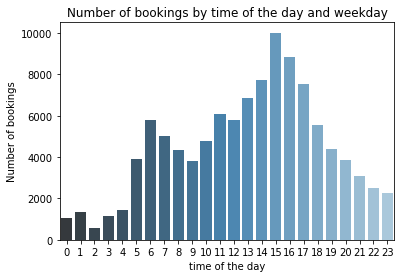

In [90]:
#Number of bookings by time of the day and weekday
weekdays_group = trips[trips["weekdays"] < 5]
hour_of_day__weekday = weekdays_group.start_time.dt.hour.value_counts()
ax = sns.barplot(x=hour_of_day__weekday.index, y=hour_of_day__weekday, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='time of the day') 
ax.set_title('Number of bookings by time of the day and weekday')

We can see a quite early "rushhour" from 6am to 7am and 15pm to 16pm.

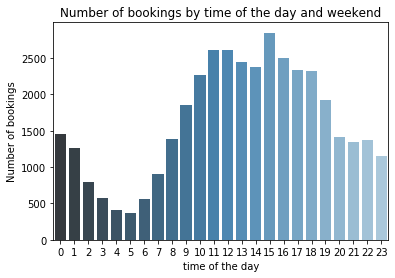

In [112]:
#Number of bookings by time and weekend 
weekend_group = trips[trips["weekdays"] > 4]
hour_of_day_weekend = weekend_group.start_time.dt.hour.value_counts()
ax = sns.barplot(x=hour_of_day_weekend.index, y=hour_of_day_weekend, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='time of the day') 
ax.set_title('Number of bookings by time of the day and weekend')
plt.savefig("../reports/figures/bookings_by_time_otd_weekend.png", dpi = 300)


When we compare this graph to weekdays, we see that less bikes are rented on the weekend (y axis: 9.000 vs 4.000).

In [92]:
display(hour_day.describe(),hour_of_day__weekday.describe(),hour_of_day_weekend.describe())

count       24.000000
mean      6120.041667
std       3192.224241
min       1384.000000
25%       3782.000000
50%       5833.500000
75%       8481.000000
max      12869.000000
Name: start_time, dtype: float64

count       24.000000
mean      4491.291667
std       2572.862667
min        587.000000
25%       2461.500000
50%       4376.000000
75%       5871.500000
max      10021.000000
Name: start_time, dtype: float64

count      24.000000
mean     1628.750000
std       782.558416
min       374.000000
25%      1087.250000
50%      1435.500000
75%      2347.000000
max      2848.000000
Name: start_time, dtype: float64

When you compare the median you can clearly see that less bikes are rented at the weekend 

# Situational analysis

In [93]:
with open('../data/external/station_information.json') as json_file:
    data = json.load(json_file)
data = pd.DataFrame(data['data']['stations'])
data

station_id                                name short_name        lat  \
0     2351602           WESER-KURIER | Pressehaus       2910  53.076722   
1     7872668                           Am Dobben       2925  53.078194   
2     7872701                      Am Speicher XI       2926  53.097556   
3     7872739                  Bahnhof Blumenthal       2927  53.182889   
4     7872765                Bahnhof Bremen-Farge       2928  53.205417   
..        ...                                 ...        ...        ...   
78   16521413                   Irgendwo Festival       2920  53.057878   
79   17322575  Mondelez Deutschland Services GmbH       2921  53.091283   
80   17322791  Die Sparkasse Bremen Mühlenviertel       2922  53.101909   
81   17322858    Am Waller Strandpark Waller Sand       2923  53.103056   
82   29359657                        IKEA Brinkum       2924  53.027197   

         lon region_id  capacity  
0   8.803943       379       5.0  
1   8.823250       379       NaN  
2   8.770056       379       NaN  
3   8.580278       379       NaN  
4   8.517000       379       NaN  
..       ...       ...       ...  
78  8.786745       379       6.0  
79  8.775759       379       6.0  
80  8.880113       379       6.0  
81  8.753035       379       6.0  
82  8.803090       379       5.0  

[83 rows x 7 columns]

In [94]:
data.rename(
    columns={
        "short_name": "start_place",
        "name" :"start_name",
    },
    inplace=True
)

In [95]:
display(trips.info(), data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146881 entries, 80400 to 111800
Data columns (total 18 columns):
bike              146881 non-null int64
bike_type         146881 non-null int64
identification    146881 non-null int64
start_time        146881 non-null datetime64[ns]
end_time          146881 non-null datetime64[ns]
duration_sec      146881 non-null float64
start_lng         146881 non-null float64
start_lat         146881 non-null float64
end_lng           146881 non-null float64
end_lat           146881 non-null float64
start_place       146881 non-null float64
end_place         146881 non-null float64
start_plz         146881 non-null object
end_plz           146881 non-null object
month             146881 non-null int64
booking_date      146881 non-null object
weekdays          146881 non-null int64
duration_min      146881 non-null float64
dtypes: datetime64[ns](2), float64(8), int64(5), object(3)
memory usage: 21.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

None

None

In [96]:
#prepare for merge
trips["start_place"] = trips.start_place.astype(int)
data["start_place"] = data.start_place.astype(int)
trips["end_place"] = trips.end_place.astype(int)

data = data.sort_values(by=['start_place'], ascending=True)

columns = ["capacity", "region_id", "lon", "lat", "station_id"]
data = data.drop(columns, axis = 1)

In [97]:
data_start = data


In [98]:
data_start

start_name  start_place
0   WESER-KURIER | Pressehaus         2910
11           Flughafen Bremen         2911
38           Universum Bremen         2912
70    hanseWasser Bremen GmbH         2913
72               Messe Bremen         2914
..                        ...          ...
67      GEWOBA | Heideplatz 1         2989
61      KAEFER Isoliertechnik         2990
68              Waller Straße         2991
69  Caroline Henschel Strasse         2992
62             Uni Bremen TAB         2997

[83 rows x 2 columns]

In [99]:
trips = trips.sort_values(by=['start_place'], ascending=True)

In [100]:
station_information = pd.merge_asof(trips, data_start, on='start_place')


In [101]:
station_information

bike  bike_type  identification          start_time  \
0       20685         71        12099440 2019-01-20 00:13:00   
1       20709         71        21522361 2019-09-04 16:59:00   
2       20615         71        21522074 2019-09-04 16:58:00   
3       20898         71        21521883 2019-09-04 16:54:00   
4       20850         71        21522018 2019-09-04 16:53:00   
...       ...        ...             ...                 ...   
146876  20932         71         7873805 2019-02-20 21:08:00   
146877  20954         71         7873825 2019-02-05 07:56:00   
146878  20738         71        12949723 2019-02-24 10:44:00   
146879  20850         71        12828517 2019-02-18 16:49:00   
146880  20641         71        12846472 2019-02-19 18:57:00   

                  end_time  duration_sec  start_lng  start_lat   end_lng  \
0      2019-01-20 00:23:00         600.0   8.812554  53.076481  8.804828   
1      2019-09-04 17:11:00         720.0   8.809529  53.063280  8.789537   
2      2019-09-04 17:06:00         480.0   8.882584  53.076409  8.879430   
3      2019-09-04 17:03:00         540.0   8.797864  53.080387  8.798058   
4      2019-09-04 17:05:00         720.0   8.836291  53.083627  8.813061   
...                    ...           ...        ...        ...       ...   
146876 2019-02-20 21:43:00        2100.0   8.860495  53.109130  8.799639   
146877 2019-02-05 09:02:00        3960.0   8.860495  53.109130  8.852417   
146878 2019-02-24 11:14:00        1800.0   8.860495  53.109130  8.815242   
146879 2019-02-18 17:09:00        1200.0   8.860495  53.109130  8.841717   
146880 2019-02-19 19:13:00         960.0   8.860495  53.109130  8.841806   

          end_lat  start_place  end_place start_plz end_plz  month  \
0       53.084196            0          0     28195   28195      1   
1       53.067018            0          0     28201   28199      9   
2       53.075422            0          0     28329   28329      9   
3       53.094591            0          0     28195   28215      9   
4       53.075560            0          0     28209   28195      9   
...           ...          ...        ...       ...     ...    ...   
146876  53.069444        29860       2962     28359   28199      2   
146877  53.107139        29860       2963     28359   28359      2   
146878  53.084467        29860          0     28359   28215      2   
146879  53.083538        29860          0     28359   28209      2   
146880  53.083187        29860          0     28359   28209      2   

       booking_date  weekdays  duration_min      start_name  
0        2019-01-20         6          10.0             NaN  
1        2019-09-04         2          12.0             NaN  
2        2019-09-04         2           8.0             NaN  
3        2019-09-04         2           9.0             NaN  
4        2019-09-04         2          12.0             NaN  
...             ...       ...           ...             ...  
146876   2019-02-20         2          35.0  Uni Bremen TAB  
146877   2019-02-05         1          66.0  Uni Bremen TAB  
146878   2019-02-24         6          30.0  Uni Bremen TAB  
146879   2019-02-18         0          20.0  Uni Bremen TAB  
146880   2019-02-19         1          16.0  Uni Bremen TAB  

[146881 rows x 19 columns]

In [102]:
data_end = data
data_end.rename(
    columns={
        "start_place": "end_place",
        "start_name" :"end_name",
    },
    inplace=True
)

In [103]:
station_information = pd.merge_asof(station_information.sort_values(by=['end_place'], ascending=True), data_end, on='end_place')

In [104]:
station_information = station_information.sort_values(by=['start_time'], ascending=True)

In [105]:
station_information.head()

bike  bike_type  identification          start_time  \
0       20685         71        12099440 2019-01-20 00:13:00   
142809  20626         71        10278649 2019-01-20 00:16:00   
5837    20617         71        12099749 2019-01-20 00:40:00   
5838    20795         71        12099872 2019-01-20 00:47:00   
110399  20813         71         7873840 2019-01-20 00:55:00   

                  end_time  duration_sec  start_lng  start_lat   end_lng  \
0      2019-01-20 00:23:00         600.0   8.812554  53.076481  8.804828   
142809 2019-01-20 04:47:00       16260.0   8.884911  53.078923  8.884911   
5837   2019-01-20 00:44:00         240.0   8.801623  53.067878  8.793217   
5838   2019-01-20 00:54:00         420.0   8.814744  53.084841  8.801135   
110399 2019-01-20 23:10:00       80100.0   8.845743  53.106418  8.845743   

          end_lat  start_place  end_place start_plz end_plz  month  \
0       53.084196            0          0     28195   28195      1   
142809  53.078923         2985       2985     28329   28329      1   
5837    53.064244            0          0     28201   28201      1   
5838    53.094596            0          0     28215   28215      1   
110399  53.106418         2912       2912     28359   28359      1   

       booking_date  weekdays  duration_min                   start_name  \
0        2019-01-20         6          10.0                          NaN   
142809   2019-01-20         6         271.0  GEWOBA | Kurt-Schumacher 11   
5837     2019-01-20         6           4.0                          NaN   
5838     2019-01-20         6           7.0                          NaN   
110399   2019-01-20         6        1335.0             Universum Bremen   

                           end_name  
0                               NaN  
142809  GEWOBA | Kurt-Schumacher 11  
5837                            NaN  
5838                            NaN  
110399             Universum Bremen

In [106]:
#most used start_place
#pd.set_option("display.max.rows", trips.shape[0]+1)
station_information.start_name.value_counts()


Hauptbahnhof / Übersee Museum       5746
WESER-KURIER | Pressehaus           1954
GOP / Steigenberger                 1475
Uni Bremen                          1111
Park Hotel                          1018
                                    ... 
Bahnhof Vegesack                     167
Am Waller Strandpark Waller Sand     122
Bahnhof Blumenthal                    84
Bahnhof Bremen-Farge                  80
Irgendwo Festival                     32
Name: start_name, Length: 73, dtype: int64

The first three stations are very central or the main station. On the 4th place we have the university.

In [107]:
#most used end_place
station_information.end_name.value_counts()

Hauptbahnhof / Übersee Museum       4374
WESER-KURIER | Pressehaus           1701
GOP / Steigenberger                 1303
Uni Bremen                          1056
Haltestelle Wartburgstraße           930
                                    ... 
Findorffmarkt                        143
Am Waller Strandpark Waller Sand     114
Bahnhof Blumenthal                    84
Bahnhof Bremen-Farge                  82
Irgendwo Festival                     29
Name: end_name, Length: 73, dtype: int64

In [108]:
#most popular roads: start_place to end_place
most_pr = (
    station_information.groupby(['start_name', 'end_name'])
      .agg({'duration_min':['count','min','max','mean','median','std','var']})
      .reset_index().sort_values(('duration_min','count'), ascending=False)
)
most_pr.head(n=20)



start_name  \
                                                       
800                    Hauptbahnhof / Übersee Museum   
621                     Haltestelle Borgfelder Allee   
1295                                      Park Hotel   
1619                       WESER-KURIER | Pressehaus   
518                              GOP / Steigenberger   
1239  Oberneulander Heerstr. / Rockwinkeler Heerstr.   
1263                                 P und R Sielhof   
83                            Anne Conway / Wohnheim   
219                                      Bremen 1860   
576                    Haltestelle Alfred-Faust-Str.   
466                      GEWOBA | Kurt-Schumacher 11   
1468                                   Twiedelftsweg   
1568                                Universum Bremen   
753                            Haltestelle Weserwehr   
1504                                      Uni Bremen   
437                            GEWOBA | Heideplatz 1   
895                                Jacobs University   
1423                                  Tabak Quartier   
481                          GEWOBA | Ludwig-Beck 2a   
1193          Mühlenfeldstr. / Rockwinkeler Heerstr.   

                                            end_name duration_min       \
                                                            count  min   
800                    Hauptbahnhof / Übersee Museum         1141  4.0   
621                     Haltestelle Borgfelder Allee          409  4.0   
1295                                      Park Hotel          391  4.0   
1619                       WESER-KURIER | Pressehaus          360  4.0   
518                              GOP / Steigenberger          358  4.0   
1239  Oberneulander Heerstr. / Rockwinkeler Heerstr.          350  4.0   
1263                                 P und R Sielhof          321  4.0   
83                            Anne Conway / Wohnheim          300  4.0   
219                                      Bremen 1860          287  4.0   
576                    Haltestelle Alfred-Faust-Str.          286  4.0   
466                      GEWOBA | Kurt-Schumacher 11          276  4.0   
1468                                   Twiedelftsweg          262  4.0   
1568                                Universum Bremen          249  4.0   
753                            Haltestelle Weserwehr          244  4.0   
1504                                      Uni Bremen          242  4.0   
437                            GEWOBA | Heideplatz 1          232  4.0   
895                                Jacobs University          231  4.0   
1423                                  Tabak Quartier          224  4.0   
481                          GEWOBA | Ludwig-Beck 2a          223  4.0   
1193          Mühlenfeldstr. / Rockwinkeler Heerstr.          219  4.0   

                                                          
         max       mean median         std           var  
800   1418.0  73.510955   29.0  107.412245  11537.390450  
621   1284.0  40.792176    7.0  136.324955  18584.493468  
1295   850.0  66.874680    7.0  116.017780  13460.125280  
1619   707.0  69.594444   18.0  105.161936  11059.032838  
518    714.0  76.337989   20.0  122.093114  14906.728581  
1239   742.0  23.937143    7.0   74.295673   5519.847041  
1263  1026.0  37.732087    7.0  102.157950  10436.246748  
83    1141.0  52.933333    7.0  131.297215  17238.958751  
219    844.0  25.170732    7.0   91.520196   8375.946273  
576    452.0  17.010490    7.0   50.276881   2527.764802  
466    839.0  71.789855    7.0  148.465629  22042.042951  
1468   765.0  24.874046    7.0   79.096160   6256.202466  
1568  1335.0  96.437751    8.0  171.612411  29450.819698  
753    965.0  51.991803    7.0  113.787073  12947.497875  
1504   615.0  67.471074   13.0  103.905046  10796.258496  
437    836.0  31.392241    7.0   84.328447   7111.287039  
895    400.0  23.709957    7.0   52.400032   2745.763335  
1423   652.0  48.571429    7.0  110.564042  12224.407431  


Mondelez is a housing company, who cooperates with WK-Bikes: https://www.weser-kurier.de/bremen/stadtteile/stadtteile-bremen-sued_artikel,-wkbikes-werden-mit-fotovoltaik-ausgestattet-_arid,1848221.html
The first 20 most taken roads seem to be round trips

In [109]:
# Most popular zones
station_information.start_name.value_counts()
df_origin_freq = station_information.start_name.value_counts().reset_index()
df_origin_freq.rename(
    columns={
        "index": "rental_zone",
        "start_name": "start",
    },
    inplace=True
)
df_origin_freq
df_origin_freq.columns = ['rental_zone','start']
df_dest_freq = station_information.end_name.value_counts().reset_index()
df_dest_freq.rename(
    columns={
        "index": "rental_zone",
        "start_place": "end",
    },
    inplace=True
)
df_dest_freq.columns = ['rental_zone','end']

popular_zones_merged = pd.merge(df_origin_freq, df_dest_freq, on='rental_zone')
popular_zones_merged['diff'] = popular_zones_merged.end - popular_zones_merged.start
popular_zones_merged

rental_zone  start   end  diff
0      Hauptbahnhof / Übersee Museum   5746  4374 -1372
1          WESER-KURIER | Pressehaus   1954  1701  -253
2                GOP / Steigenberger   1475  1303  -172
3                         Uni Bremen   1111  1056   -55
4                         Park Hotel   1018   914  -104
..                               ...    ...   ...   ...
68                  Bahnhof Vegesack    167   162    -5
69  Am Waller Strandpark Waller Sand    122   114    -8
70                Bahnhof Blumenthal     84    84     0
71              Bahnhof Bremen-Farge     80    82     2
72                 Irgendwo Festival     32    29    -3

[73 rows x 4 columns]

Here you see, that at "Hauptbahnhof / Übersee Museum" more trips are starting than ending.

In [110]:
# High bicycle demand
popular_zones_merged.sort_values('diff').head()

rental_zone  start   end  diff
0   Hauptbahnhof / Übersee Museum   5746  4374 -1372
1       WESER-KURIER | Pressehaus   1954  1701  -253
19                   BSAG-Zentrum    655   446  -209
2             GOP / Steigenberger   1475  1303  -172
18          Gottfried-Menken-Str.    660   488  -172

In [111]:
# High bicycle supply
popular_zones_merged.sort_values('diff', ascending=False).head()

rental_zone  start  end  diff
28                    Haltestelle Borgfelder Allee    567  612    45
40  Oberneulander Heerstr. / Rockwinkeler Heerstr.    454  480    26
49                                   Twiedelftsweg    391  412    21
55          Mühlenfeldstr. / Rockwinkeler Heerstr.    308  319    11
58                               Jacobs University    255  264     9

We can see, that few stations have too many bikes but there are stations where the demand is quite high, so that they may lack on bikes.

## Monthly Distributions

In [132]:
monthly_distro = trips

In [133]:
for col in ['start_time']:
    monthly_distro['month'] = pd.DatetimeIndex(monstly_distro['start_time']).month
    monthly_distro['booking_date'] = monstly_distro.start_time.dt.date
    monthly_distro['weekdays'] = pd.DatetimeIndex(monstly_distro['start_time']).weekday

In order to identify pontentially interesing dates later, we are gonna visualize the number of bookings per day for each month.

Text(0.5, 1.0, 'January')

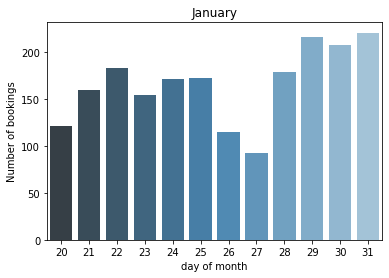

In [134]:
day_of_month_jan = monthly_distro[monthly_distro['start_time'].dt.month == 1].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('January')

Text(0.5, 1.0, 'February')

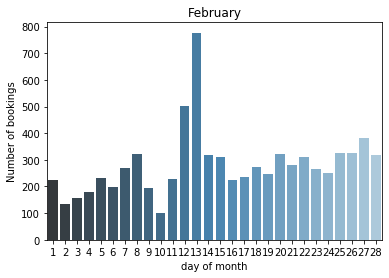

In [135]:
day_of_month_feb = monthly_distro[monthly_distro['start_time'].dt.month == 2].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_feb.index, y=day_of_month_feb, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('February')

Text(0.5, 1.0, 'March')

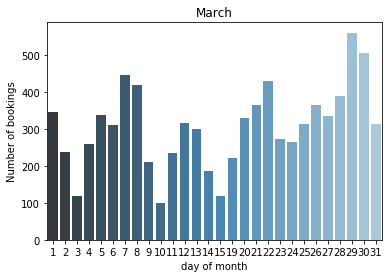

In [136]:
day_of_month_mar = monthly_distro[monthly_distro['start_time'].dt.month == 3].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_mar.index, y=day_of_month_mar, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('March')

Text(0.5, 1.0, 'April')

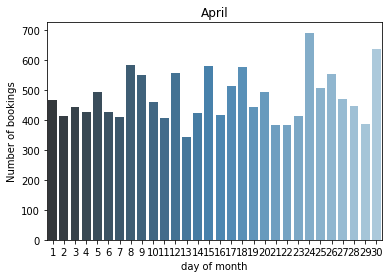

In [137]:
day_of_month_jan = monthly_distro[monthly_distro['start_time'].dt.month == 4].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('April')

Text(0.5, 1.0, 'May')

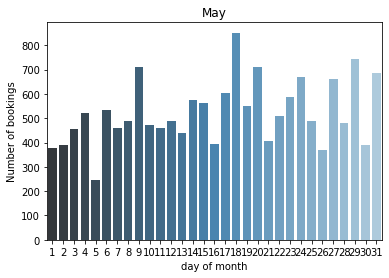

In [138]:
day_of_month_jan = monthly_distro[monthly_distro['start_time'].dt.month == 5].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('May')

Text(0.5, 1.0, 'June')

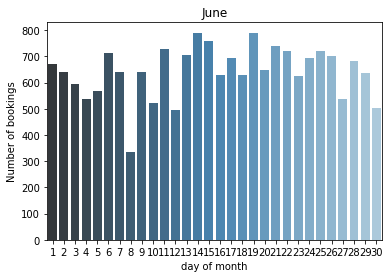

In [139]:
day_of_month_jan = monthly_distro[monthly_distro['start_time'].dt.month == 6].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('June')

Text(0.5, 1.0, 'August')

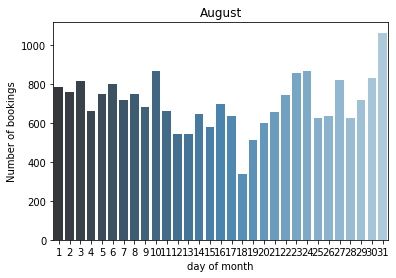

In [140]:
day_of_month_jan = monthly_distro[monthly_distro['start_time'].dt.month == 8].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('August')

Text(0.5, 1.0, 'September')

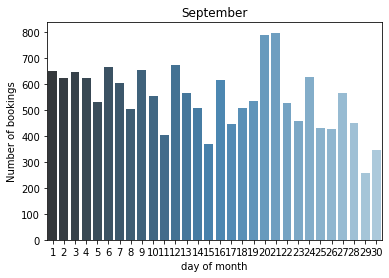

In [141]:
day_of_month_jan = monthly_distro[monthly_distro['start_time'].dt.month == 9].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('September')

Text(0.5, 1.0, 'October')

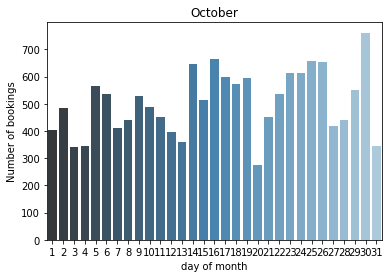

In [142]:
day_of_month_jan = monthly_distro[monthly_distro['start_time'].dt.month == 10].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('October')

Text(0.5, 1.0, 'November')

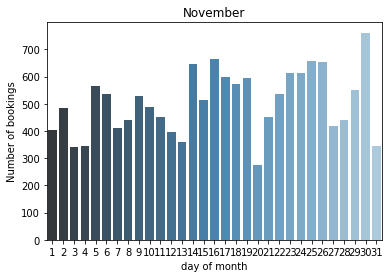

In [143]:
day_of_month = monthly_distro[monthly_distro['start_time'].dt.month == 11].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('November')

Text(0.5, 1.0, 'December')

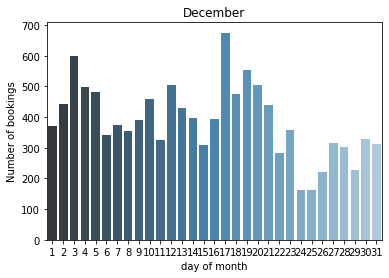

In [144]:
day_of_month_jan = monthly_distro[monthly_distro['start_time'].dt.month == 12].start_time.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('December')

Furthermore, we look at the average duration of each trip per month

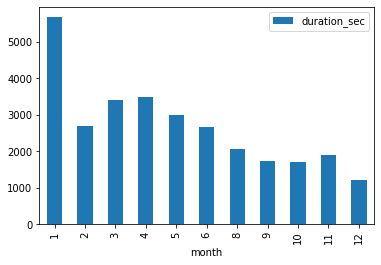

In [145]:
monthly_distro.groupby('month').duration_sec.mean().to_frame().plot(kind="bar")


Interestingly, the average duration is by far the longest in January. We need to determine the number of bookings per month in order to conclude wether those bookings are outliers. 

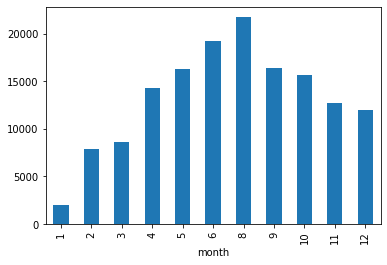

In [147]:
# Number of bookins per month
monthly_distro.groupby('month').bike.count().plot(kind="bar")

The number of bookings seems normally distributed and looks as expected. The summer months contain a lot of bookings while the colder months have subsequently less and less bookings. January has (apart from July missing) the fewest bookings. Thus, we can derive that the long booking duration observed in the prior plot is caused by outliers.